<a href="https://www.kaggle.com/code/rachelz0/diabetes-prediction?scriptVersionId=209619619" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier, StackingClassifier, VotingClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import (train_test_split, GridSearchCV, 
    StratifiedKFold,cross_val_score, RandomizedSearchCV)
from sklearn.metrics import (confusion_matrix, recall_score, ConfusionMatrixDisplay, 
                             roc_auc_score, classification_report, accuracy_score, 
                             balanced_accuracy_score, make_scorer, precision_score, f1_score)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import (StandardScaler, MinMaxScaler, RobustScaler, 
                                   FunctionTransformer, OneHotEncoder, 
                                   PowerTransformer, PolynomialFeatures, OrdinalEncoder)
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
import missingno as msno
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


    

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pima-indians-diabetes-database/diabetes.csv


# 1. Introduction
Diabetes is a chronic metabolic disease defined by an elevated amount of blood glucose, which if left unchecked can cause long-term damage, dysfunction, and failure of multiple organs, including the heart, eyes, kidneys, blood vessels, and nerves. The most common type of diabetes is Type 2 which usually occurs in adults. It is the result of the body becoming resistant to insulin (which can lead to large amounts of insulin in the blood) or doesn't make enough insulin.

Type 1 occurs when the body's immune system damages the insulin-producing cells in the pancreas resulting in insufficient amount of insulin. The third type is gestational, a form that affects pregnant women.

According to the world health organization ([WHO](#Ref)), about 830 million people worldwide have diabetes and more than half are not receiving treatment. Determining the risk factors, early diagnosis and prediction of diabetes could provide patients with the opportunity to take appropriate preventative and treatment strategy. 

In this project, we use the Pima Indian dataset to build a machine learning model to accurately predict the likelihood of a patient having diabetes.

# 2. Dataset Columns
We will start exploring the dataset. As per source, each patient has the following information collected about them:

1. `Glucose`: glucose plasma concentration (mg/dL)
2. `BloodPressure`: Diastolic blood pressure (mm Hg)
3. `SkinThickness`: Triceps skin fold thickness (mm)
4. `Insulin`: 2-Hour serum insulin (mu U/ml)
5. `BMI`: Body mass index (weight in kg/(height in m)$^2$)
6. `DiabetesPedigreeFunction`: Diabetes pedigree function
7. `Age`: age of patient (years)
8. `Outcome`: output variable (0: normal, 1: diabetic)
   

# 3. Exploratory Data Analysis

In [2]:
# Load in the data and check its shape
diabetes_df = pd.read_csv('/kaggle/input/pima-indians-diabetes-database/diabetes.csv')
diabetes_df.shape

(768, 9)

- The dataset contains 768 rows or samples and 9 columns. Let's take a closer look at the first rows.

In [3]:
# Check the first five rows
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


- The dataset seems to contain numerical features only. 
- Some features contain zero values.

Next, we verify the dtypes of the columns and check for the presence of any missing values.

In [4]:
# Check Dataframe column informstion
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


- All columns are numeric. `2` are encoded as floats and `7` as integers.
- There are no missing values. All features contain `768` non-null entries. 
- However, missing values can be encoded in different ways such as zeroes. 

Next we get the summary of statistics.

In [5]:
# Get a summary of descriptive statistics 
diabetes_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


From the table above we can observe that:

- The average age of the patients is about `33` years. The youngest patient is `21` and the oldest is `81` years old.
- The median of `Insulin` is lower than its mean by ~`49` mu U/ml, indicating that it could be a right-skewed distribution likely caused by outliers.
- `Pregnancies`, `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin` and `BMI` have minimum of zero.
- `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin` and `BMI` cannot be zero. These will be regarded as missing and cleaned up later.

## 3.1 Distribution of the target variable
Here we check the prevalence of the classes in the `Outcome` variable.

In [6]:
# Get the absolute counts of the target
diabetes_df.Outcome.value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [7]:
# Get the frequences of the target
diabetes_df.Outcome.value_counts(normalize=True)

Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64

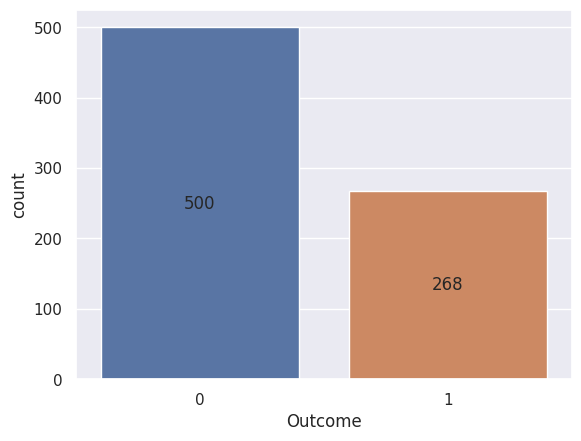

In [8]:
# Visualize the target variable
sns.set()
ax = sns.countplot(x='Outcome', data=diabetes_df)
ax.bar_label(ax.containers[0], label_type="center")
plt.show()

- About 35% of observations belong to class 1, which are the individuals with diabetes. There is a moderate class imbalance. This might affect the perfomance of our models and should be taken into consideration.

Next, we look at how diabetes (`Outcome`) is related to `Age`.

In [9]:
# Make a copy of the diabetes DataFrame
diabetes_modif = diabetes_df.copy()
# Create age bins and their labels
age_bins = [18, 30, 40, 50, 60, 70, 120]
age_labels = ['20s', '30s', '40s', '50s', '60s', '70+']

# Create age_group column
diabetes_modif["age_group"] = pd.cut(x=diabetes_modif['Age'], bins=age_bins, labels=age_labels)

# Groupby age_group and access the target variable
grouped = diabetes_modif.groupby('age_group')['Outcome']

counts = grouped.value_counts().reset_index()                        
counts

,age_group,Outcome,count
0,20s,0,327
1,20s,1,90
2,30s,0,81
3,30s,1,76
4,40s,1,64
5,40s,0,49
6,50s,1,31
7,50s,0,23
8,60s,0,18
9,60s,1,7


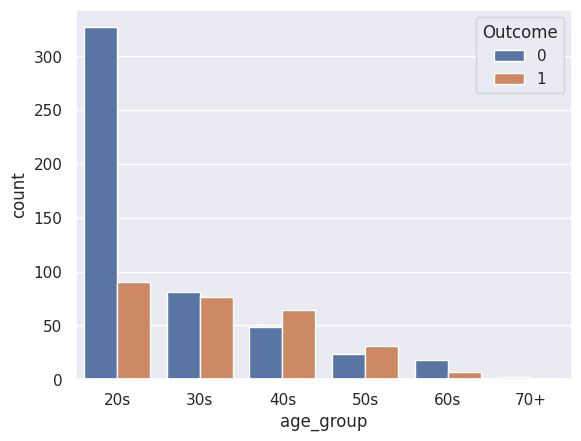

In [10]:
# Display age_ranges against target variable
sns.barplot(data = counts, x='age_group',y= 'count', hue='Outcome')
plt.show()

- The dataset is highly skewed towards women in the 20's and most of them have no diabetes. This could potentially bias our model.
- Diabetes was most common in women 40-59 years old (`57%`), followed by women ages 30-39 years old (`48%`).
- It would be interesting to check how model performance is affected by using individual or binned values of the `Age` feature.

# 4. Data Preprocessing

The following preprocessing steps will be performed
- Zeros  will be replaced with NaNs. 
- The NaNs will be imputed.
- Feature scaling
- Below we perform step 1. The other steps will be performed inside Pipelines.

## 4.1 Replacing zeros with NaNs

In [11]:
# Convert zeros to NaNs
subset = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for feature in subset:
    diabetes_df[feature] = diabetes_df[feature].replace(0, np.nan)

# Display column information to see the changes
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   763 non-null    float64
 2   BloodPressure             733 non-null    float64
 3   SkinThickness             541 non-null    float64
 4   Insulin                   394 non-null    float64
 5   BMI                       757 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


In [12]:
# Display missing value totals
diabetes_df.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [13]:
# Display missing values as percentages
print(diabetes_df.isnull().mean()*100)


Pregnancies                  0.000000
Glucose                      0.651042
BloodPressure                4.557292
SkinThickness               29.557292
Insulin                     48.697917
BMI                          1.432292
DiabetesPedigreeFunction     0.000000
Age                          0.000000
Outcome                      0.000000
dtype: float64


- Almost half of the `Insulin` variable values are missing.
- `SkinThickness` has close to 30% missing vaues.
Next we explore further the missingness relationships of these variables.

## 4.2 Missingness analysis

<Axes: >

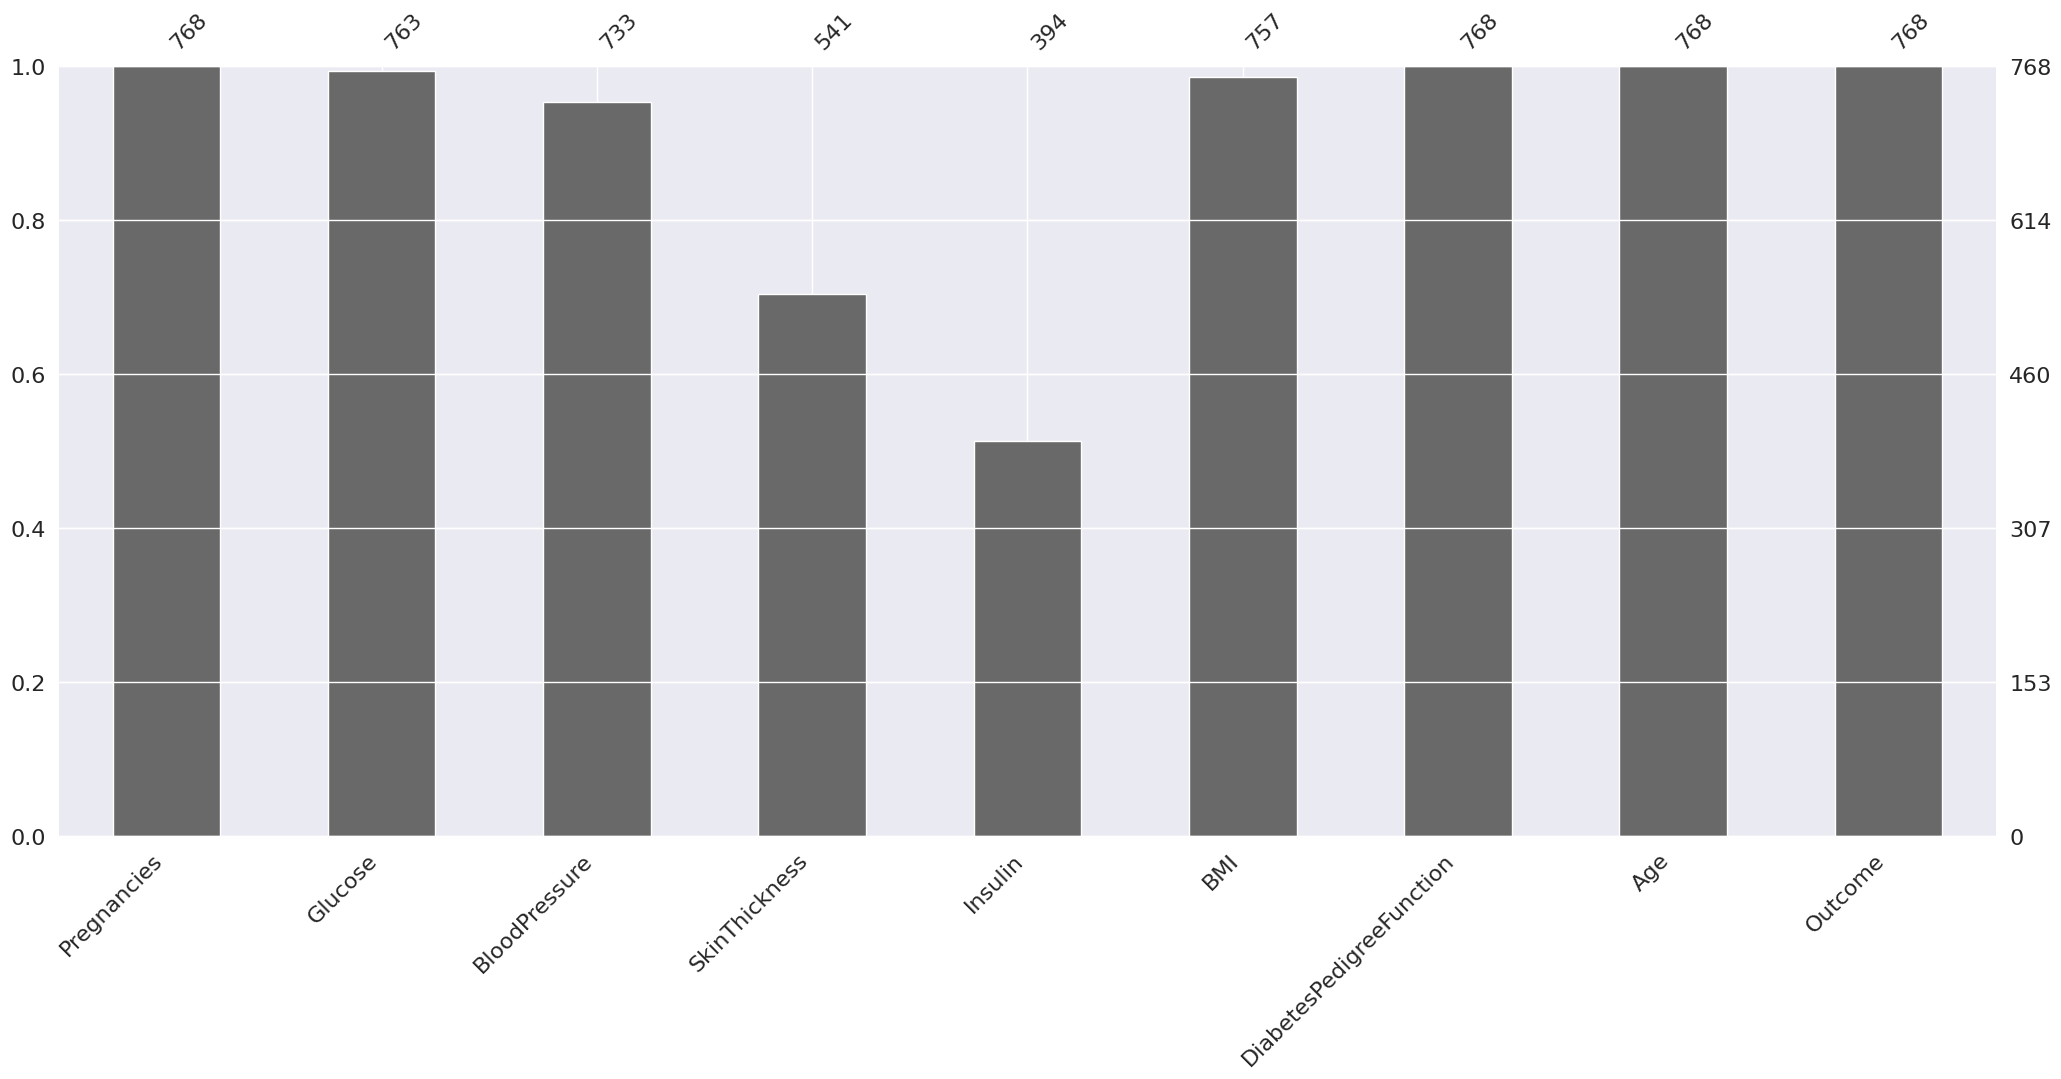

In [14]:
# Visualize the completeness of the DataFrame
msno.bar(diabetes_df)

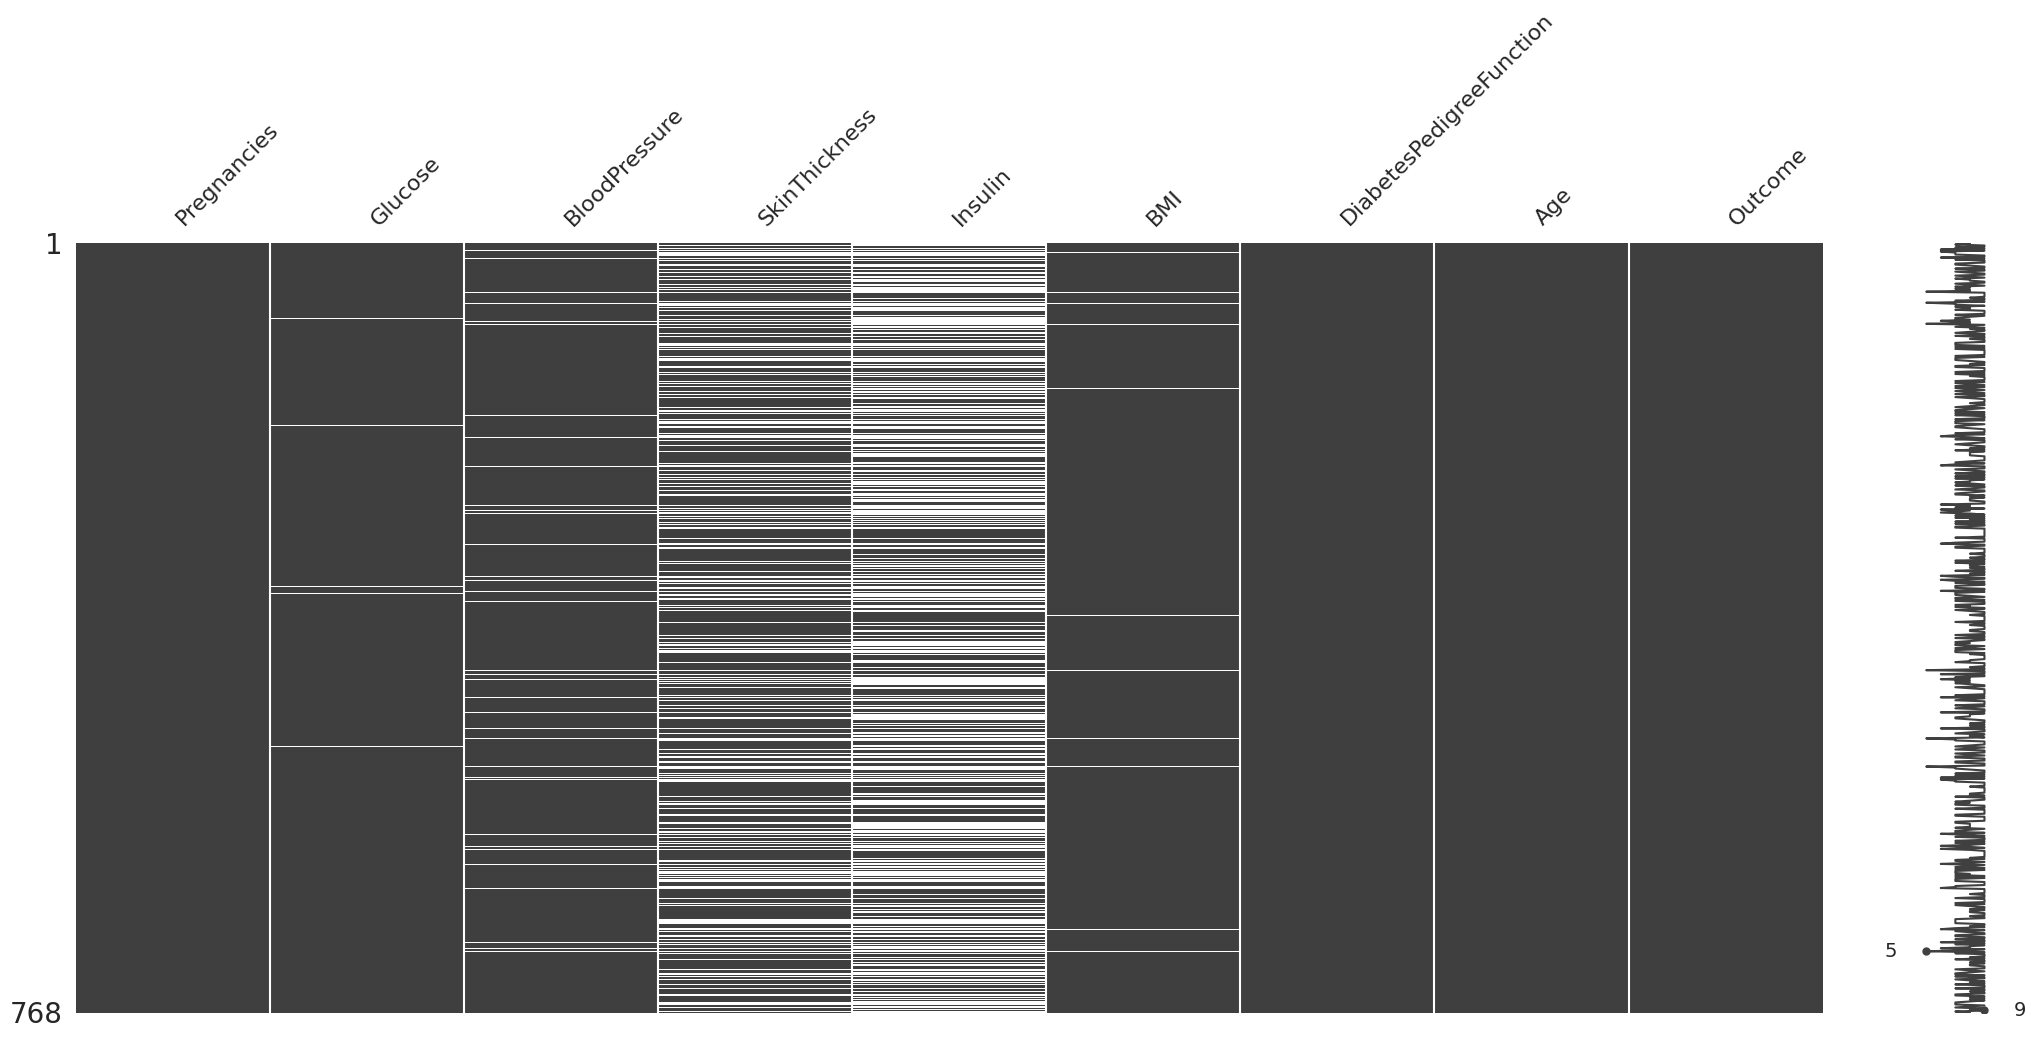

In [15]:
# Visualize missingness of the data
msno.matrix(diabetes_df)
plt.show()

- `Pregnancies`, `DiabetesPedigreeFunction`, `Age` and `Outcome` are completely populated.
- `Glucose` has the least amount of missing values and `Insulin` has the most.
- `Glucose` column values appear to be missing completely at random (MCAR).

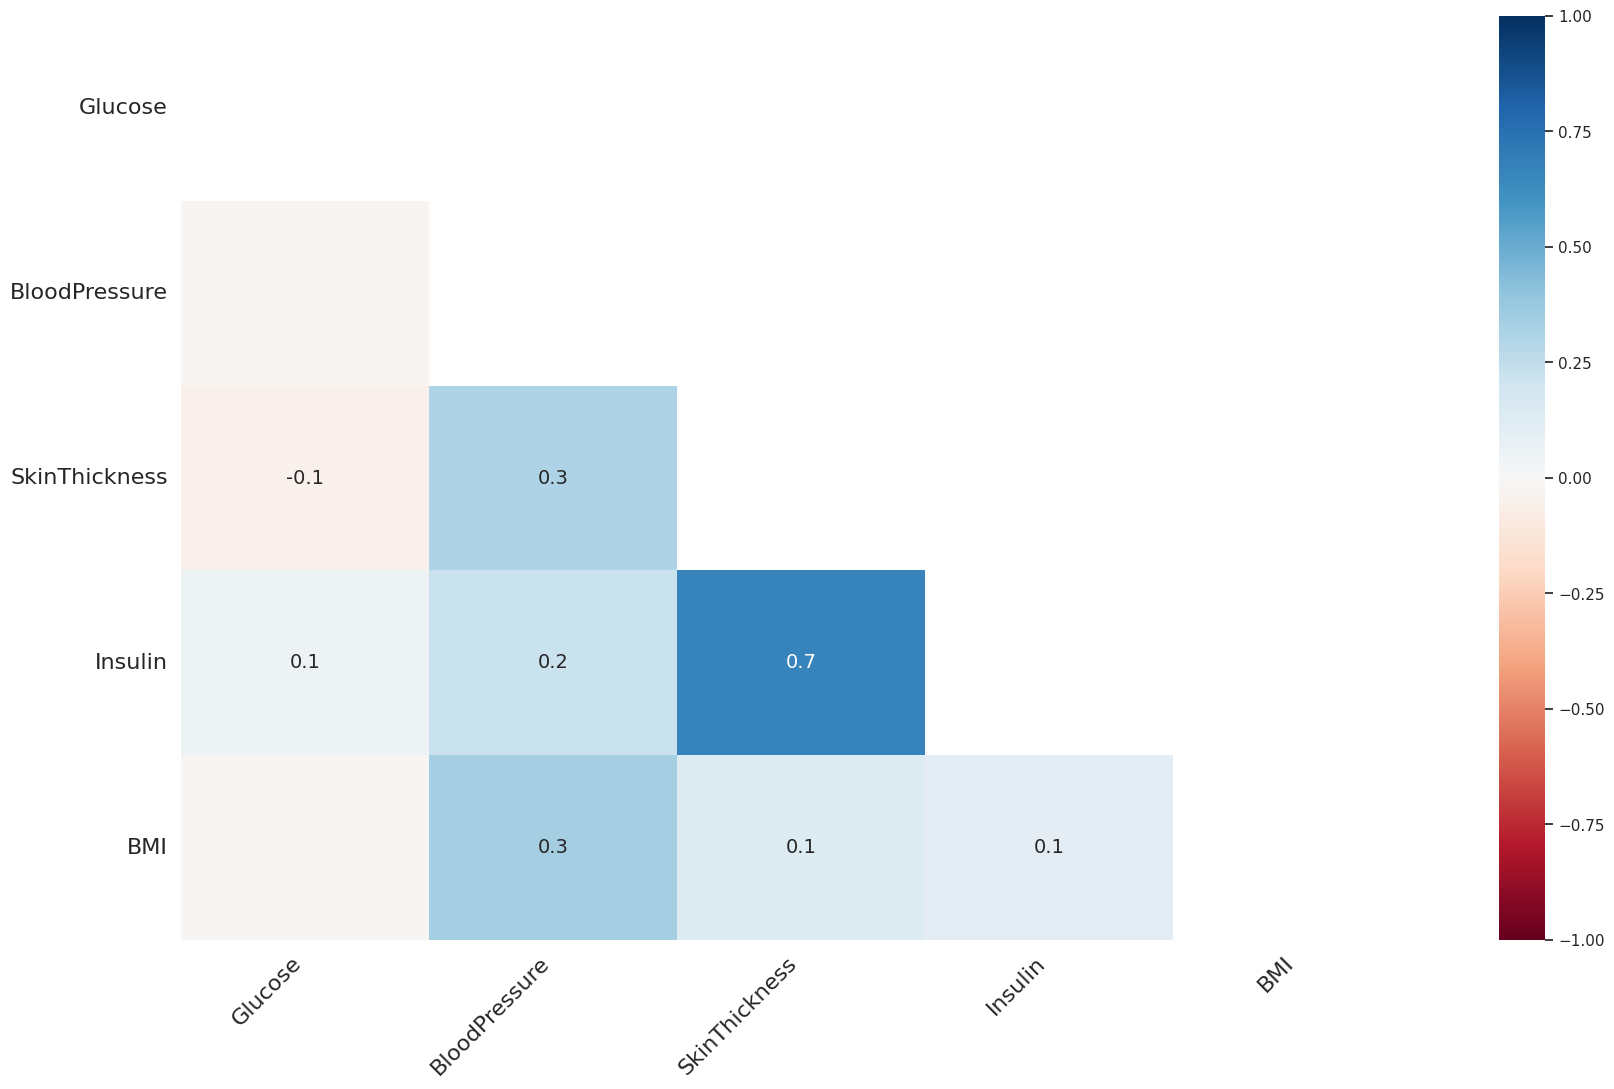

In [16]:
# Visualize the correlation of missingness between variables
msno.heatmap(diabetes_df)
plt.show()

- `Insulin` and `SkinThickness` have a stronger positive nullity correlation (`0.7` and can be described as missing not at random (MNAR).
- The nullity of `BMI` and `BloodPressure` is slightly correlated (`0.3`)

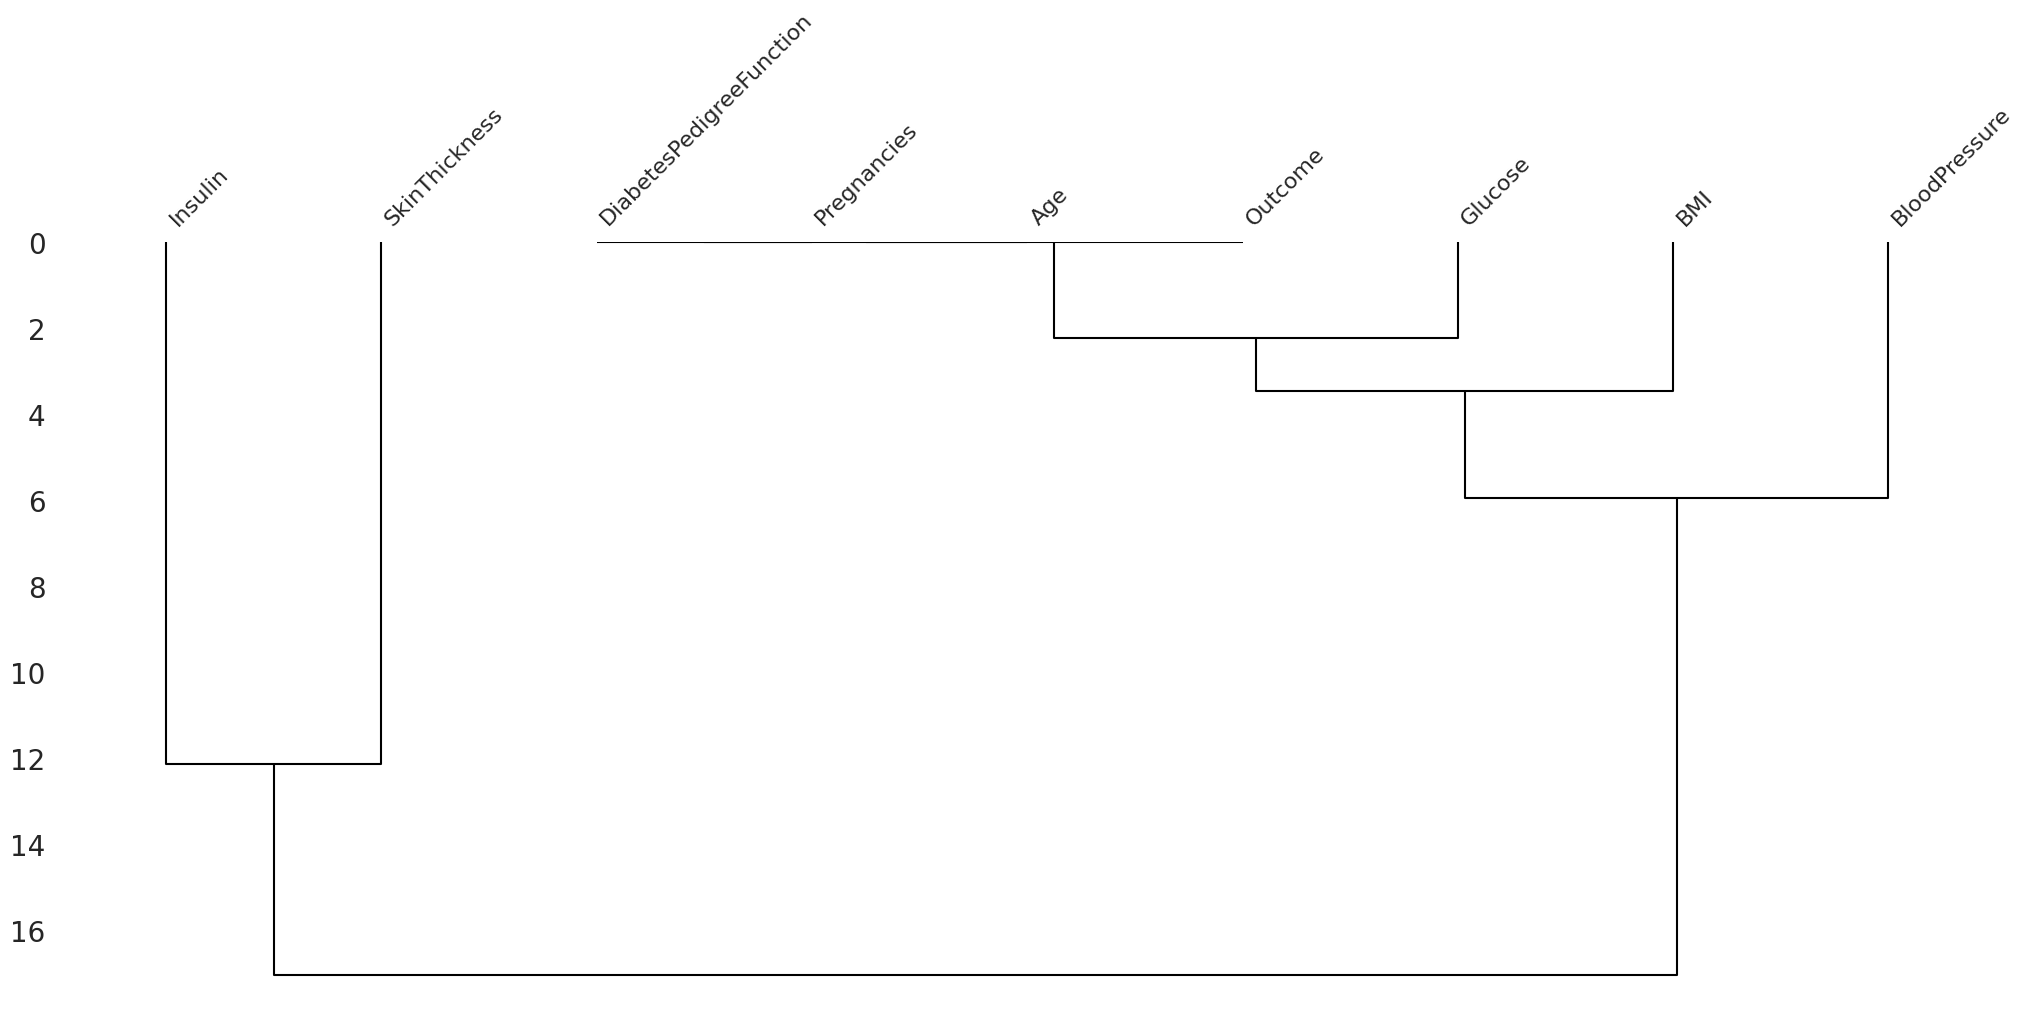

In [17]:
# Plot missingness dendrogram of diabetes
msno.dendrogram(diabetes_df)

# Show plot
plt.show()

- Two distinct groups of columns emerge, highlighting variables with high degree of null values and those with fewer null values and complete cases.
- One group consists of `SkinThickness` and `Insulin`. 
- The other group consists of the 4 columns with complete cases together with  `Glucose`, `BMI` and `BloodPressure`.
- The missingness of `Glucose` is simmilar to `BMI` than to `BloodPressure`

## 4.3 Data Visualization

### 4.3.1 Correlation Matrix

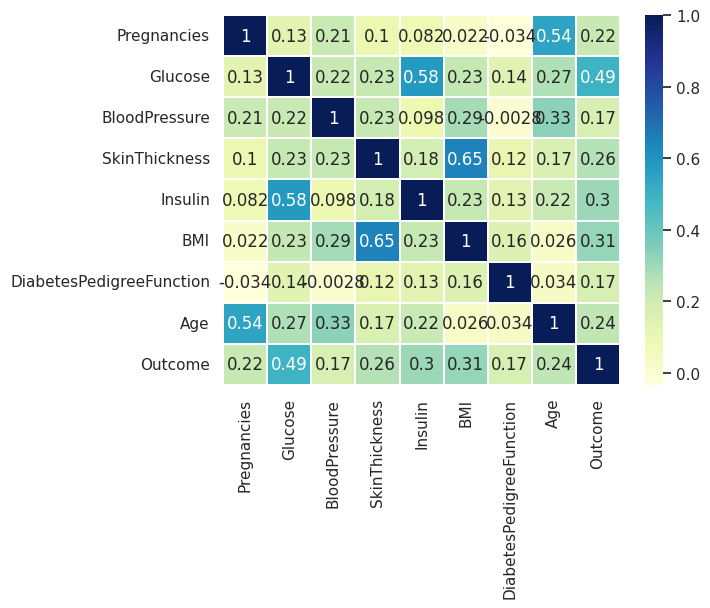

In [18]:
# Display a heatmap of the correlation matrix
sns.heatmap(diabetes_df.corr(), annot=True, linewidths=0.01, cmap="YlGnBu")
plt.show()

Most of the variables have weak correlations between each other but we can highlight the following:
- `Age` is positively correlated with `Pregnancies` (`0.54`).
- `Insulin` and `Glucose` are also positively correlated (`0.58`) 
- `BMI` and `SkinThickness` are positively correlated (`0.65`) 
- However, the correlations are not too strong so the model is unlikely going to suffer from multicollinearity. 
- `Glucose` has the highest correlation with the `Outcome` variable(`0.49`), suggesting that `Glucose` is an important feature in predicting the outcome in this dataset.
- `BMI`, `Insulin`, `SkinThickness`, `Age` may also be important features.
- `BloodPressure` and `DiabetesPedigreeFuntion` seem to be least important features.


### 4.3.2 Univariate Distributions
Below we check the distributions of the features using histograms.

In [19]:
# Create dataframe with features only
diabetes_features = diabetes_df.drop('Outcome', axis=1)

print(diabetes_features.shape)

(768, 8)


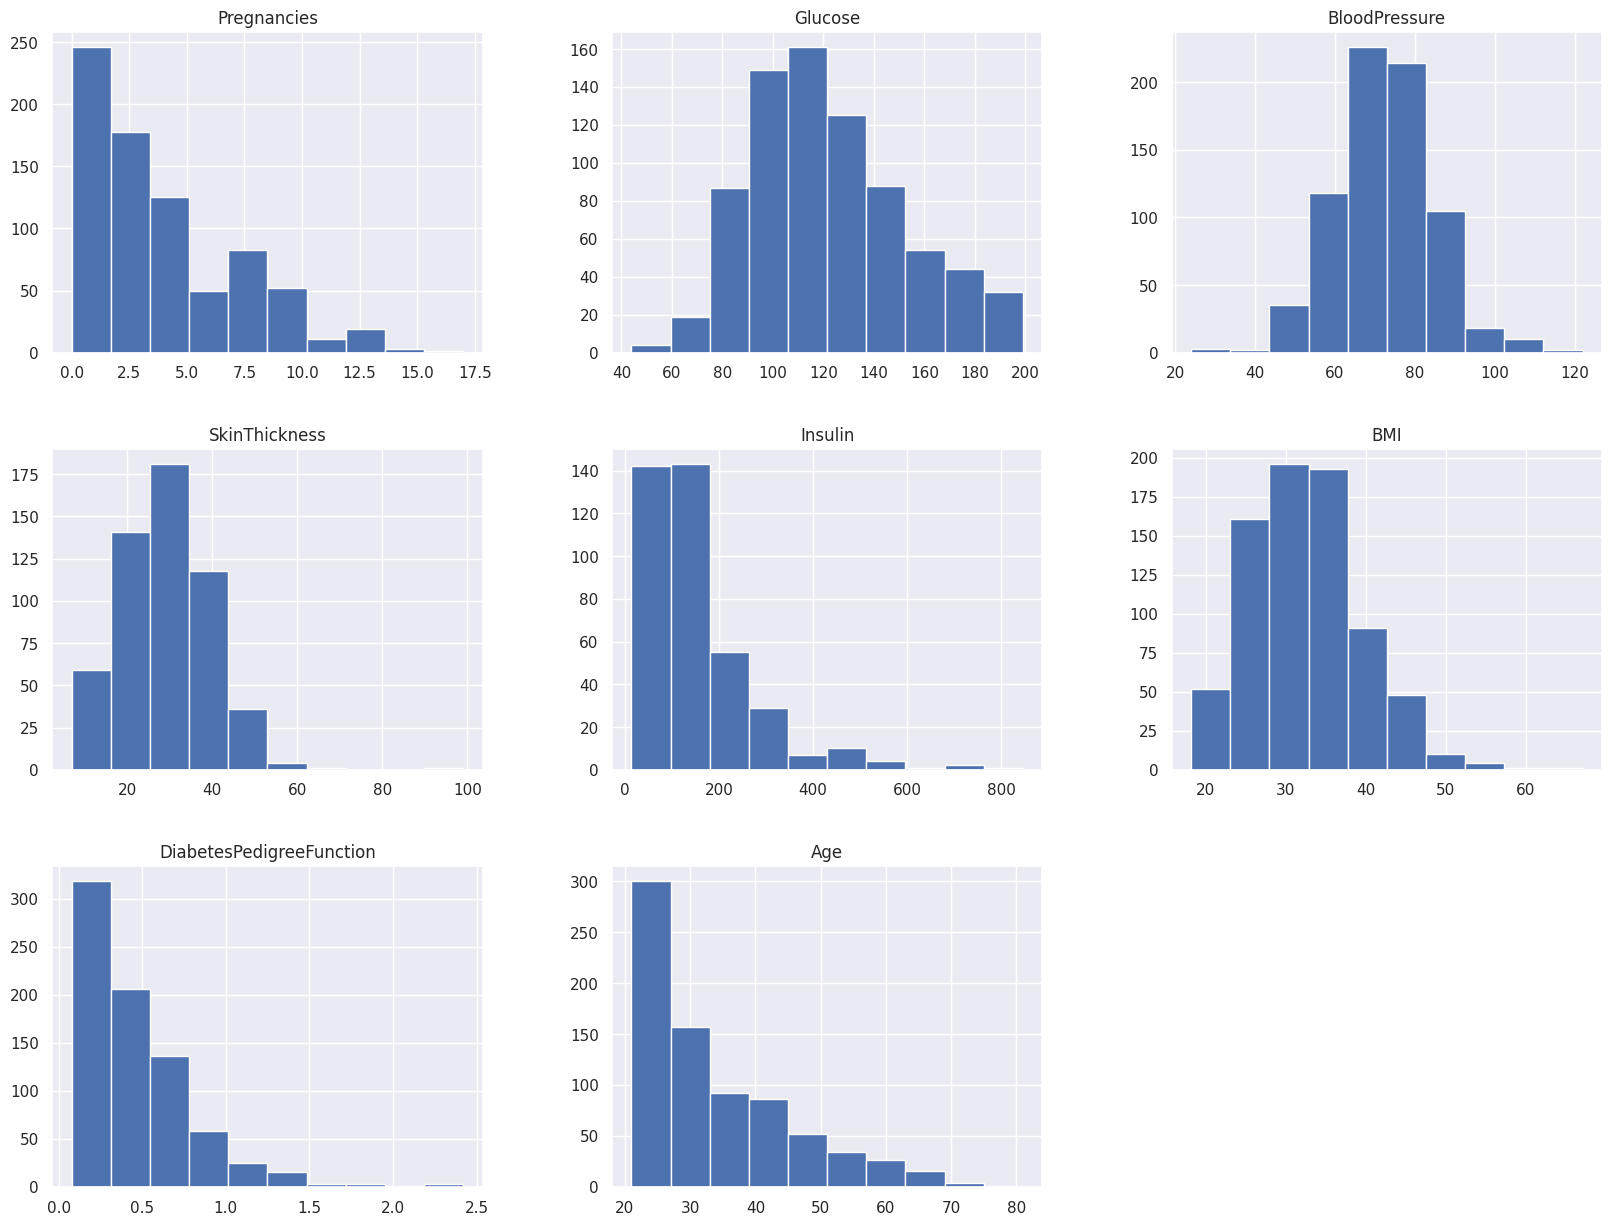

In [20]:
# Display histograms of the features
diabetes_features.hist(figsize=(20,15))
plt.show()

- The distributions of `Glucose`, `BloodPressure`, `SkinThickness` and `BMI` are close to normal whereas those of the other features (`Pregnancies`, `Insulin`, `DiabetesPedigreeFunction` and `Age`) are skewed with a tail on the right.
- The scale of the features is different. `Insulin` has the widest and `DiabetePedigreeFuction` the shortest range.
- The skewness and difference in scale can potentially harm model performance and will be reviewed later.

Next we use boxplots to visualize the distribution of the features.

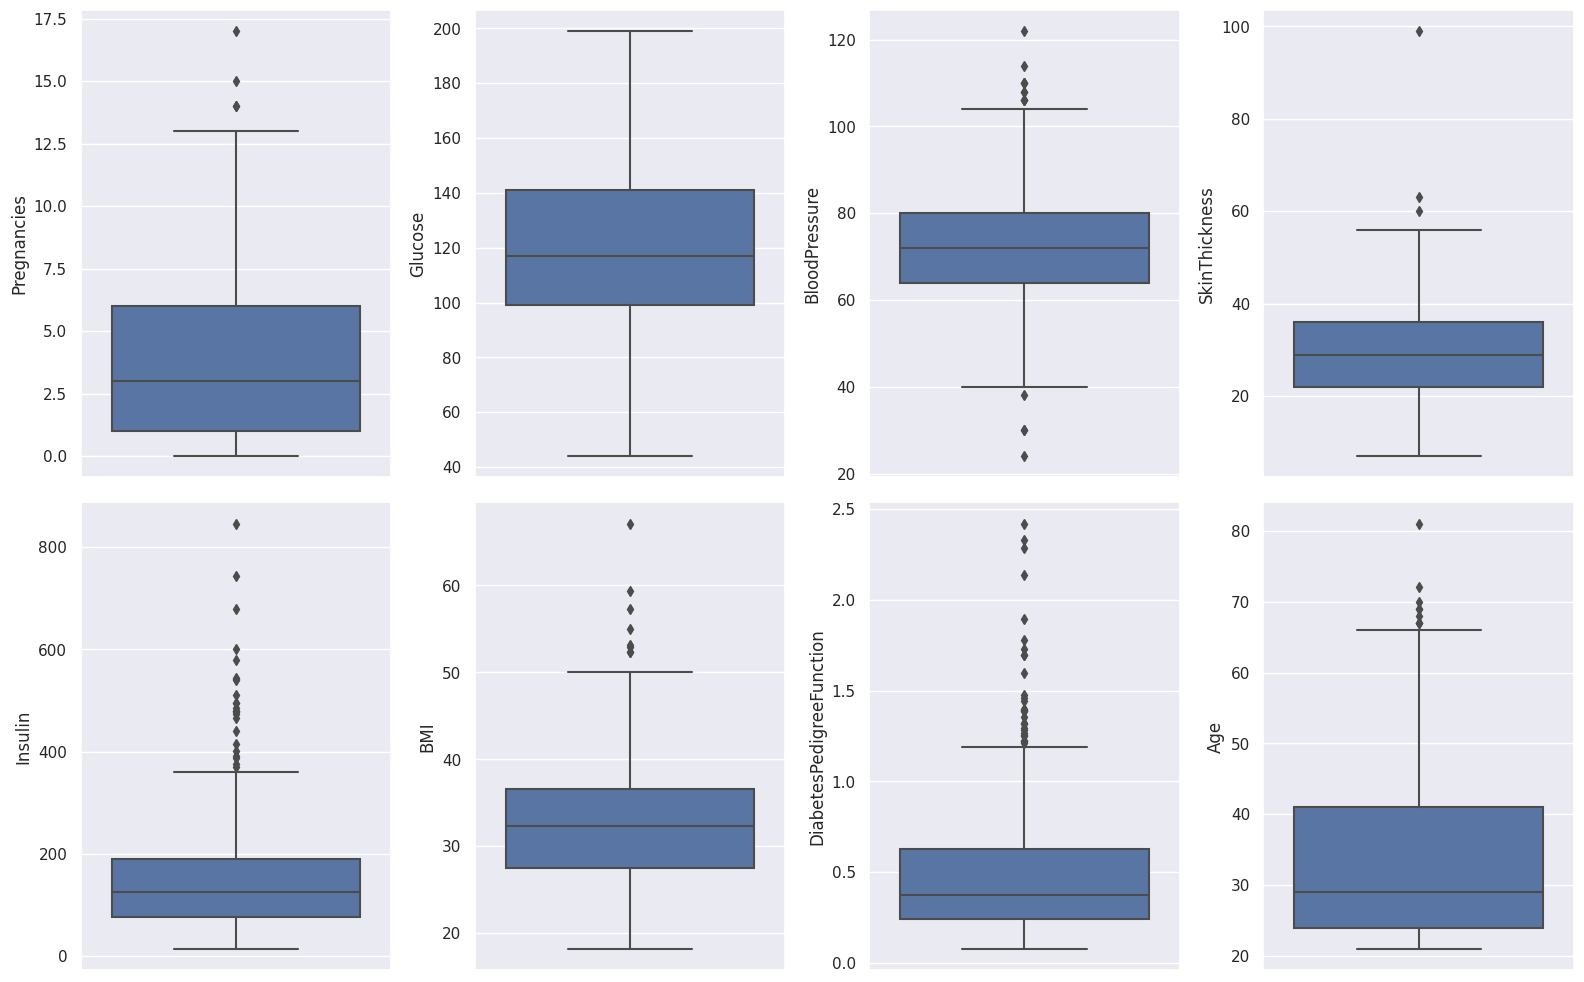

In [21]:
# Display boxplots of the features
plt.figure(figsize=(16,10))
for i,col in enumerate(diabetes_features):    
    plt.subplot(2,4, i+1)
    sns.boxplot(y=col, data=diabetes_df)

plt.tight_layout()
plt.show()

- All the features except `Glucose` have outliers. This is pronounced especially with `Insulin` and `DiabetsPedigreeFunction`.
- All the outliers in these features are beyond the upper bound except for `BloodPressure` where there cases of extreme low and extreme high blood pressure.

### 4.3.3 Bivariate analysis
Next we check whether stratifying by diabetes shows any meaningful difference in the distribution of the predictors.

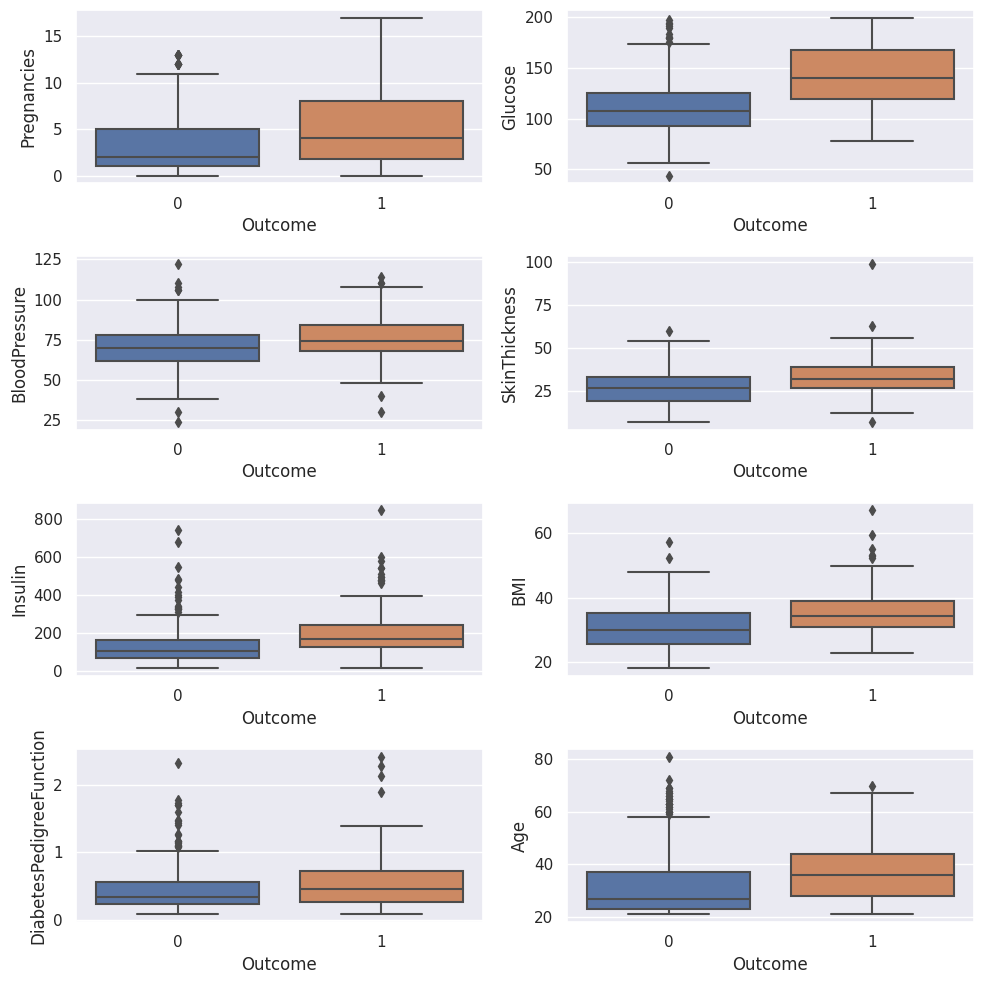

In [22]:
# Display boxplots of features conditioned with the outcome variable
plt.figure(figsize=(10,10))
for i,col in enumerate(diabetes_features):    
    plt.subplot(4,2, i+1)
    sns.boxplot(x='Outcome', y=col, data=diabetes_df)
plt.tight_layout()
plt.show()

- The distributions of the two target classes are clearly different for `Glucose`. This confirms the earlier suspicion that this feature is the most informative in the classification task. 
- Although the distributions of the other features overlap, the medians of class 1 are always higher. This is in particular noticeable for `Age`, `BMI`, `Insulin`, `Pregnancies`
- It is difficulty to discern trends in some cases because of the skewness. 

### 4.3.4 Feature Skewness

In [23]:
for feature in diabetes_features:
    print(f"{feature}: {diabetes_df[feature].skew()}")

Pregnancies: 0.9016739791518588
Glucose: 0.5309885349396285
BloodPressure: 0.13415273171959252
SkinThickness: 0.690619013984192
Insulin: 2.166463843812443
BMI: 0.5939697505712673
DiabetesPedigreeFunction: 1.919911066307204
Age: 1.1295967011444805


- The skewness value for `Insulin`, `DiabetesPedigreeFunction` and to a lesser extent `Age` are greater than one indicating that they have significant outliers.

# 5. Modeling 
In part one, the data was preprocessed by imputation and scaling and various models assessed.
In part two additional feature engineering was performed to determine whether the predictive accuracy of models could be improved.

## 5.1 Feature Matrix and Target Array

In [24]:
# Create feature matrix and target array
X = diabetes_df.drop('Outcome', axis=1)
y = diabetes_df.Outcome
print(X.shape, y.shape)

(768, 8) (768,)


## 5.2 Train Test Split

In [25]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=12)

In [26]:
# Checking for separation in the datasets
print("Y_train: ", sum(y_train == 0))
print("Y_train: ", sum(y_train == 1))
print("Y_test: ", sum(y_test == 0))
print("Y_test: ", sum(y_test == 1))

Y_train:  350
Y_train:  187
Y_test:  150
Y_test:  81


Both cases (class = 1) and non-cases are present in both the training and test sets

## 5.3 Imputation and Scaling
Imputation and scaling will be performed inside Pipelines but in some cases the data will be used without Pipelines.

In [27]:
# Instantiate the imputer and scaler objects
imputer = KNNImputer()
sc = StandardScaler()

# Impute and transform
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Standardize the data
sc.fit(X_train_imputed, y)
X_train_pre = pd.DataFrame(sc.transform(X_train_imputed), columns=X_train.columns)
X_test_pre = pd.DataFrame(sc.transform(X_test_imputed), columns= X_test.columns)

## 5.4 Finding the Best Machine Learning Model
We are going to test different models to check which one is the best at accurately predicting diabetes.

### 5.4.1 Create a class that receives a model as an input

In [28]:
class ClfSwitcher(BaseEstimator):

    def __init__(self, estimator = LogisticRegression()):
        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    def score(self, X, y):
        return self.estimator.score(X, y)

### 5.4.2 Add the class in step 1 to a Pipeline

In [29]:
# Build a Pipeline
clf_pipeline = Pipeline(steps=[
    ('imputation', KNNImputer(n_neighbors=3)),
    ('scaler', StandardScaler()),
    ('model', ClfSwitcher())
])

### 5.4.3 Perform Grid search

In [30]:
# Create a grid of estimators
grid_params = [
    {'model__estimator': [LogisticRegression(class_weight='balanced', random_state=12)]},
    {'model__estimator': [SVC(class_weight='balanced', probability=True, random_state=12)]},
    {'model__estimator': [KNeighborsClassifier(n_neighbors=5)]},
    {'model__estimator': [RandomForestClassifier(random_state=12)]}
]
# Create the GridSearchCV object
gs = GridSearchCV(clf_pipeline, grid_params, scoring='balanced_accuracy', refit=True)

# Fit the GridsearchCV object to the training set
gs.fit(X_train, y_train)

# Retrieve the best score and best parameters
best_score = gs.best_score_
best_params = gs.best_params_

# Get test set accuracy
test_score = gs.score(X_test, y_test)

print(f"Best Score of train set: {best_score} \n")
print(f"Best parameter set: {best_params}\n")
print(f"Test Score: {test_score}")

Best Score of train set: 0.7245908660439552 

Best parameter set: {'model__estimator': LogisticRegression(class_weight='balanced', random_state=12)}

Test Score: 0.804074074074074


### 5.4.4 Step 4: Print grid search results as a table

In [31]:
# Display grid search results as a DataFrame
pd.DataFrame(gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__estimator,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.032555,0.001622,0.013397,0.001007,"LogisticRegression(class_weight='balanced', ra...",{'model__estimator': LogisticRegression(class_...,0.803233,0.687218,0.753814,0.674324,0.704365,0.724591,0.047689,1
1,0.099538,0.000840,0.018829,0.001863,"SVC(class_weight='balanced', probability=True,...",{'model__estimator': SVC(class_weight='balance...,0.736343,0.660902,0.669527,0.707722,0.683135,0.691526,0.027434,2
2,0.026217,0.001036,0.029603,0.000970,KNeighborsClassifier(),{'model__estimator': KNeighborsClassifier()},0.669454,0.732331,0.667620,0.662355,0.624802,0.671312,0.034594,3
3,0.280537,0.007160,0.012825,0.000573,RandomForestClassifier(random_state=12),{'model__estimator': RandomForestClassifier(ra...,0.676700,0.657143,0.701182,0.649614,0.637897,0.664507,0.022262,4


- The logistic regression model was the overall winner in terms of  best cv score (0.72) and speed.
- SVC was second with a cv score of 0.69.
- The random forest classifier came in last with a score of 0.66.
- Next, hyperparameter tuning is going to be performed in order to try to improve model perfomance.

## 5.5 Tuning the Logistic Regression Model

In [32]:
# Create steps
steps = [("imp_mean", KNNImputer(n_neighbors=3)), 
          ("scaler", StandardScaler()), 
         ("logreg", LogisticRegression(class_weight='balanced', random_state=12))]

# Set up pipeline
pipe_lr = Pipeline(steps)
params = {"logreg__solver": ["newton-cg", "saga", "lbfgs"],
         "logreg__C": np.linspace(0.001, 1.0, 10)}

# Create the GridSearchCV object
gs_lr = GridSearchCV(pipe_lr, param_grid=params, scoring='balanced_accuracy', refit=True)
gs_lr.fit(X_train, y_train)

# Compute and print performance
print(f"Tuned Logistic Regression Parameters: {gs_lr.best_params_}", end="\n\n\n")
print(f"Best CV Score {gs_lr.best_score_}", end="\n\n")
print(f"Test accuracy of best grid search hypers: {gs_lr.best_estimator_.score(X_test, y_test)}", end="\n\n\n")
      

Tuned Logistic Regression Parameters: {'logreg__C': 0.223, 'logreg__solver': 'newton-cg'}


Best CV Score 0.7217252590936802

Test accuracy of best grid search hypers: 0.8008658008658008




### 5.5.1 The Tuned Logistic Regression Model

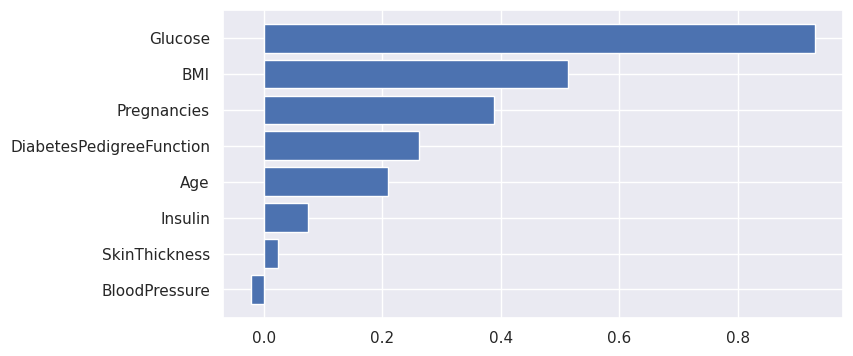

In [33]:
# Instantiate the tuned logistic regression
clf_lr = LogisticRegression(C=0.223, solver='newton-cg', class_weight='balanced', random_state=12)

# Fit on the imputed and scaled train test
clf_lr.fit(X_train_pre, y_train)

# Create a list of original variable names from the training DataFrame
original_variables = list(X_train.columns)

# Extract the coefficients of the logistic regression estimator
model_coefficients = clf_lr.coef_[0]

# Create a dataframe of the variables and coefficients 
coefficient_df = pd.DataFrame({"Variable" : original_variables, "Coefficient": model_coefficients})

# Sort the coefficient values in ascending order
coefficient_df = coefficient_df.sort_values("Coefficient")

# Display with a barplot
plt.figure(figsize=(8, 4))
plt.barh(coefficient_df["Variable"], coefficient_df["Coefficient"])
plt.show()

- Features with predictive power with the logistic regression model are:
    1. `Glucose`
    2. `BMI`
    3. `Pregnancies`
    4. `DiabetesPedigreeFunction`
    5. `Age`
- There is negligible contribution from `Insulin` and `SkinThickness`
- `BloodPressure` had a small negative effect.

LogisticRegression:
Accuracy: 0.7965, Balanced Accuracy: 0.7979

ROC AUC: 0.8774, Recall: 0.80

Precision: 0.68, F1 score: 0.73

 Classification Report
               precision    recall  f1-score   support

           0       0.88      0.79      0.84       150
           1       0.68      0.80      0.73        81

    accuracy                           0.80       231
   macro avg       0.78      0.80      0.78       231
weighted avg       0.81      0.80      0.80       231



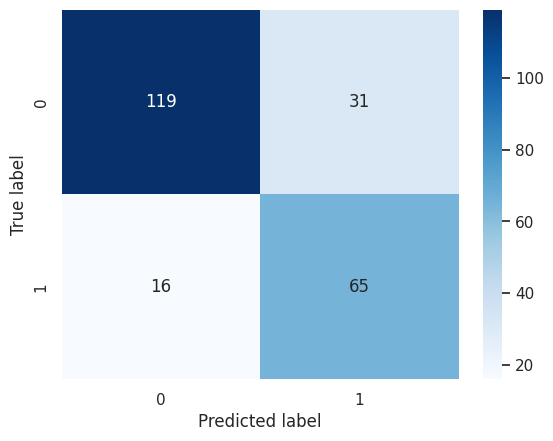

In [34]:
# Make predictions on the imputed and scaled test set
pred_lr = clf_lr.predict(X_test_pre)

# Determine overall accuracy
acc = accuracy_score(y_test, pred_lr)

# Get the balanced accuracy
bal_acc = balanced_accuracy_score(y_test, pred_lr)

# Get the recall score
recall = recall_score(y_test, pred_lr)

# Get the precision score
precision = precision_score(y_test, pred_lr)

# Get the f1-score
f1 = f1_score(y_test, pred_lr)

# Get the area under the curve
auc = roc_auc_score(y_test, clf_lr.predict_proba(X_test_pre)[:,1])

print(f"LogisticRegression:\nAccuracy: {acc:.4f}, Balanced Accuracy: {bal_acc:.4f}\n")
print(f"ROC AUC: {auc:.4f}, Recall: {recall:.2f}\n")
print(f"Precision: {precision:.2f}, F1 score: {f1:.2f}\n")

# Display classification report
print(f" Classification Report\n {classification_report(y_test, pred_lr)}")

# Display confusion matrix
sns.heatmap(confusion_matrix(y_test, pred_lr), annot=True, fmt='.3g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


## 5.6 Tuning the SVC Model

In [35]:
# Create Pipeline steps
steps = [("imp_mean", KNNImputer(n_neighbors=3)),
         ("scaler", StandardScaler()),
         ('SVC', SVC(class_weight='balanced', probability=True, random_state=12))
    ]
# Set up Pipeline
pipe_svc = Pipeline(steps)

# Create the GridSearchCV param_grid
params = {'scaler': [MinMaxScaler(), RobustScaler(), StandardScaler(), 'passthrough'],
         "SVC__C": [0.1, 1, 10],
         "SVC__gamma": [0.00001, 0.0001, 0.001, 0.01, 0.1]}

# Instantiate the GridSearchCV object and run the search
gs_svc = GridSearchCV(pipe_svc, param_grid=params, refit=True)

# Fit the GridSearchCV object on the training data
gs_svc.fit(X_train, y_train)

# Report the best parameters and the corresponding score
print("Best CV params", gs_svc.best_params_, end="\n\n\n")
print("Best CV accuracy", gs_svc.best_score_, end="\n\n")

# Report the test accuracy using these best parameters
print("Test accuracy of best grid search hypers:", gs_svc.score(X_test, y_test), end="\n\n\n")




Best CV params {'SVC__C': 10, 'SVC__gamma': 0.0001, 'scaler': StandardScaler()}


Best CV accuracy 0.7280200761509172

Test accuracy of best grid search hypers: 0.7575757575757576




### 5.6.1 The Tuned SVC Model

SVC:
Accuracy: 0.7576, Balanced Accuracy: 0.7537

ROC AUC: 0.8560, Recall: 0.74

Precision:0.63, F1 score: 0.68

 Classification Report
               precision    recall  f1-score   support

           0       0.85      0.77      0.80       150
           1       0.63      0.74      0.68        81

    accuracy                           0.76       231
   macro avg       0.74      0.75      0.74       231
weighted avg       0.77      0.76      0.76       231




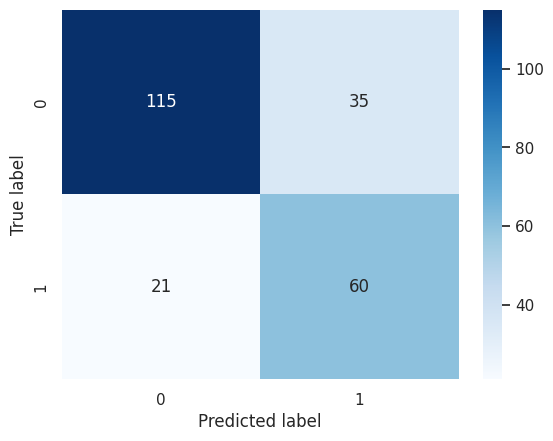

In [36]:
# Instantiate the tuned SVC model
clf_svc = SVC(C=10, gamma=0.0001, class_weight='balanced', probability=True, random_state=12)

# Fit on the training data
clf_svc.fit(X_train_pre, y_train)

# Make predictions on the test set
pred_svc = clf_svc.predict(X_test_pre)

# Get performance metrics on the test set
acc = accuracy_score(y_test, pred_svc)
bal_acc = balanced_accuracy_score(y_test, pred_svc)
recall = recall_score(y_test, pred_svc)
precision = precision_score(y_test, pred_svc)
f1 = f1_score(y_test, pred_svc)
auc = roc_auc_score(y_test, clf_svc.predict_proba(X_test_pre)[:,1])

# Print performance metrics
print(f"SVC:\nAccuracy: {acc:.4f}, Balanced Accuracy: {bal_acc:.4f}\n")
print(f"ROC AUC: {auc:.4f}, Recall: {recall:.2f}\n")
print(f"Precision:{precision:.2f}, F1 score: {f1:.2f}\n")

# Print classification report 
print(f" Classification Report\n {classification_report(y_test, pred_svc)}\n")

# Display confusion matrix
sns.heatmap(confusion_matrix(y_test, pred_svc), annot=True, fmt='.3g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


### 5.6.2 SVC Feature Importances

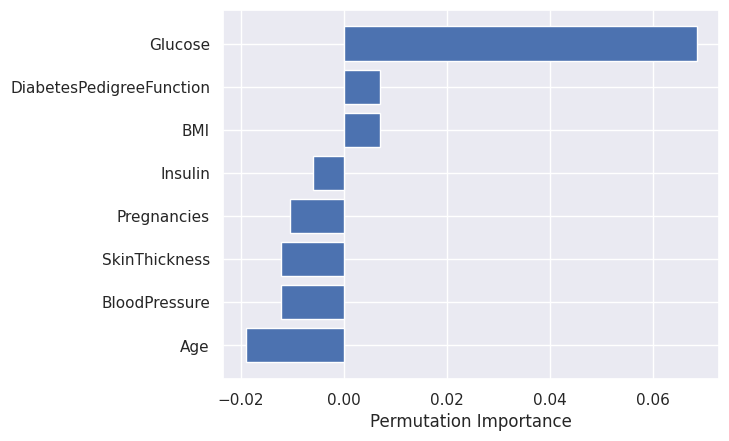

In [37]:
# Calculate permutation importances
perm_importance = permutation_importance(clf_svc, X_test_pre, y_test, random_state=41)

# Get the feature names
feature_names = X_train.columns
features = np.array(feature_names)

# Sort and plot the importances
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

- `Glucose` is the most important feature followed by `DiabetesPedigreeFunction` and `BMI`
- The rest of the features especially `Age`, `BloodPressure` and `Pregnancies` have a negative impact.

## 5.7 Tuning the Random Forest Classifier

Random Classifier:

Best CV params: {'class_weight': 'balanced_subsample', 'max_depth': 4}

Best CV accuracy: 0.7285389148547043

Accuracy: 0.8312, Balanced Accuracy: 0.8416

ROC AUC: 0.8803, Recall: 0.88

Precision: 0.71, F1 score: 0.78

Classification Report
               precision    recall  f1-score   support

           0       0.92      0.81      0.86       150
           1       0.71      0.88      0.78        81

    accuracy                           0.83       231
   macro avg       0.82      0.84      0.82       231
weighted avg       0.85      0.83      0.83       231



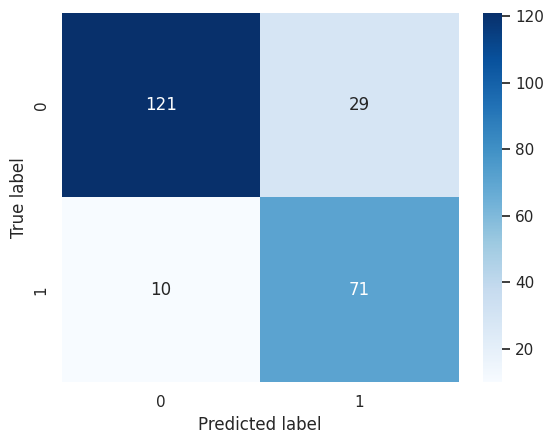

In [38]:
# Define a dictionary of hyperparameters to tune
params = {"class_weight": ['balanced', 'balanced_subsample'], "max_depth": [3, 4, 5]}

# Instantiate the RandomForest model
clf_rf = RandomForestClassifier(random_state=12)

# Create a GridSearch object
gs_rf = GridSearchCV(estimator = clf_rf, param_grid=params, scoring='balanced_accuracy', cv = 5, refit=True)

# Fit to the training data
gs_rf.fit(X_train_pre, y_train)


# Report the best parameters and the corresponding score
print("Random Classifier:\n\nBest CV params:", gs_rf.best_params_, end="\n\n")
print("Best CV accuracy:", gs_rf.best_score_, end="\n\n")

# Make predictions on the test set
pred_rf = gs_rf.predict(X_test_pre)

# Get performance metrics
acc = accuracy_score(y_test, pred_rf)
bal_acc = balanced_accuracy_score(y_test, pred_rf)
recall = recall_score(y_test, pred_rf)
precision = precision_score(y_test, pred_rf)
f1 = f1_score(y_test, pred_rf)
auc = roc_auc_score(y_test, gs_rf.predict_proba(X_test_pre)[:,1])

# Print the metrics
print(f"Accuracy: {acc:.4f}, Balanced Accuracy: {bal_acc:.4f}\n")
print(f"ROC AUC: {auc:.4f}, Recall: {recall:.2f}\n") 
print(f"Precision: {precision:.2f}, F1 score: {f1:.2f}\n")
# Print classification report 
print(f"Classification Report\n {classification_report(y_test, pred_rf)}")

# Display confusion matrix
sns.heatmap(confusion_matrix(y_test, pred_rf), annot=True, fmt='.3g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


### 5.7.1 Random Forest Feature Importances

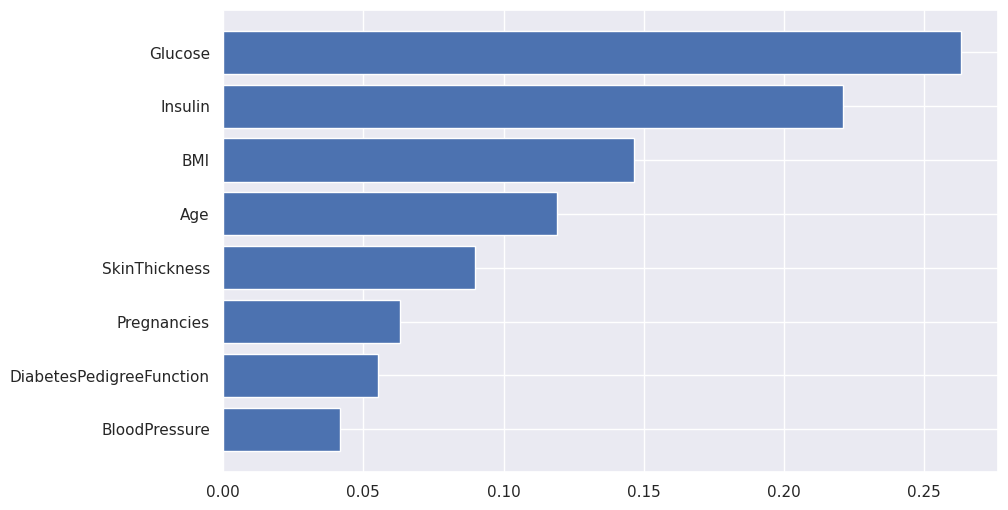

In [39]:
# Get the feature names
features = X_train.columns

# Create a DataFrame of features and their importances
feature_importance = pd.DataFrame({
    "features": features,
    "importance": gs_rf.best_estimator_.feature_importances_
})

# Sort the importances in ascending order
feature_importance = feature_importance.sort_values('importance')

# Visualize as a horizontal barplot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance["features"], feature_importance["importance"])
plt.show()

- The most predictive feature is `Glucose` followed by `Insulin`.
- Also important are `BMI`, `Age` and `SkinThickness`

## 5.8 Gradient Boost Model

In [40]:
# Instantiate a GradientBoosting model and fit the training set
clf_xgb = XGBClassifier(objective='binary:logistic', n_estimators=20, learning_rate=0.1, max_depth=3,scale_pos_weight=0.7, random_state=12)
clf_xgb.fit(X_train_pre, y_train)
print("accuracy on training set: %f" % clf_xgb.score(X_train_pre, y_train))
print("accuracy on test set: %f" % clf_xgb.score(X_test_pre, y_test))

accuracy on training set: 0.802607
accuracy on test set: 0.770563


### 5.8.1 Parameter Tuning

In [41]:
# Calculate the ratio of negative class to positive class
ratio = float(y_train.value_counts()[0]) / y_train.value_counts()[1]
ratio

1.8716577540106951

In [42]:
# Define Pipeline steps
steps = [("imp_mean", KNNImputer(n_neighbors=3)),
         ("scaler", StandardScaler()),
         ('xgb', XGBClassifier(objective='binary:logistic', random_state=12))]
 
# Construct a grid of hyperparameters to use
params_grid = {
   'xgb__learning_rate': np.arange(0.05, 1, 0.5),
    'xgb__max_depth': [4,5,6],
    'xgb__n_estimators': [20, 50, 100],
    'xgb__lambda': [2],
    'xgb__min_child_weight': [5, 6],
    'xgb__scale_pos_weight': [ratio]   
}

# Set up the pipeline
pipe_xgb = Pipeline(steps)

# Instantiate the GridSearchCV object and fit on the training set
gs_xgb = GridSearchCV(pipe_xgb, params_grid, scoring='balanced_accuracy', cv=5)
gs_xgb.fit(X_train, y_train)

# Make predictions on the test set
pred_xgb = gs_xgb.predict(X_test)

# Report the best parameters and the corresponding score
print("Best CV params", gs_xgb.best_params_, end="\n\n\n")
print("Best CV accuracy", gs_xgb.best_score_, end="\n\n")

# Report the test accuracy using these best parameters
print("Test accuracy of best grid search hypers:", gs_xgb.score(X_test, y_test), end="\n\n\n")



Best CV params {'xgb__lambda': 2, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 5, 'xgb__min_child_weight': 6, 'xgb__n_estimators': 50, 'xgb__scale_pos_weight': 1.8716577540106951}


Best CV accuracy 0.740873806136964

Test accuracy of best grid search hypers: 0.8125925925925925




### 5.8.2 The Tuned XGB Model

Accuracy: 0.8009, Balanced Accuracy: 0.8126

ROC AUC: 0.8882, Recall: 0.85

Precision: 0.67, F1 score: 0.75

Classification Report
               precision    recall  f1-score   support

           0       0.91      0.77      0.83       150
           1       0.67      0.85      0.75        81

    accuracy                           0.80       231
   macro avg       0.79      0.81      0.79       231
weighted avg       0.82      0.80      0.80       231



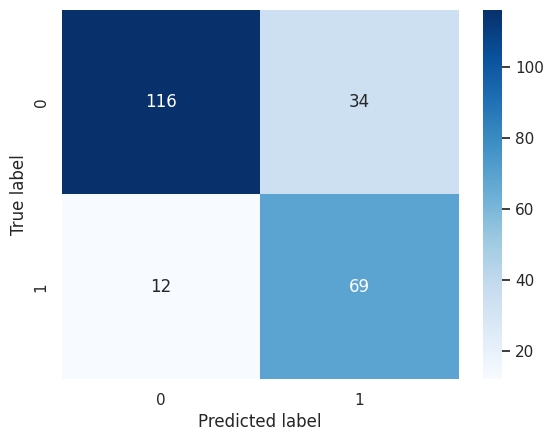

In [43]:
clf_xgb = XGBClassifier(objective='binary:logistic', reg_lambda=2, learning_rate=0.05, 
                        max_depth=5, min_child_weight=6, n_estimators=50, 
                        scale_pos_weight=1.872, random_state=12)
clf_xgb.fit(X_train_pre, y_train)

# Make predictions on the test set
pred_xgb = clf_xgb.predict(X_test_pre)

# Get performance metrics
acc = accuracy_score(y_test, pred_xgb)
bal_acc = balanced_accuracy_score(y_test, pred_xgb)
recall = recall_score(y_test, pred_xgb)
precision = precision_score(y_test, pred_xgb)
f1 = f1_score(y_test, pred_xgb)
auc = roc_auc_score(y_test, clf_xgb.predict_proba(X_test_pre)[:,1])

# Print the perfomance metrics
print(f"Accuracy: {acc:.4f}, Balanced Accuracy: {bal_acc:.4f}\n")
print(f"ROC AUC: {auc:.4f}, Recall: {recall:.2f}\n") 
print(f"Precision: {precision:.2f}, F1 score: {f1:.2f}\n")

# Print classification report 
print(f"Classification Report\n {classification_report(y_test, pred_xgb)}")


# Display confusion matrix
sns.heatmap(confusion_matrix(y_test, pred_xgb), annot=True, fmt='.3g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()



### 5.8.3 Determine Feature Importance

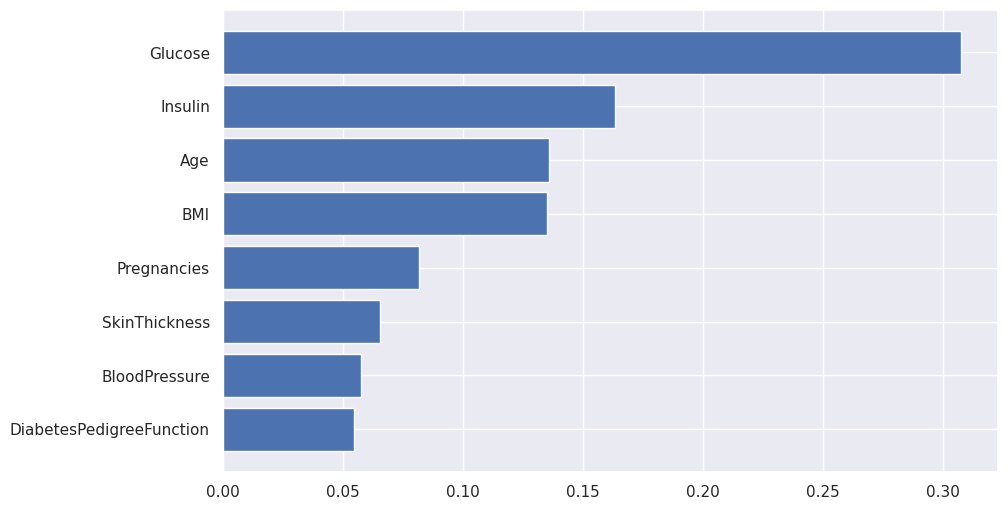

In [44]:
# Get the feature names
features = X_train.columns
clf_xgb = XGBClassifier(objective='binary:logistic', reg_lambda=2, learning_rate=0.05, 
                        max_depth=5, min_child_weight=6, n_estimators=50, 
                        scale_pos_weight=1.872)
clf_xgb.fit(X_train_pre, y_train)

# Create a DataFrame of features and their importances
feature_importance = pd.DataFrame({
    "features": features,
    "importance": clf_xgb.feature_importances_
})

# Sort the importances in ascending order
feature_importance = feature_importance.sort_values('importance')

# Visualize as a horizontal barplot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance["features"], feature_importance["importance"])
plt.show()

- For the Gradient Boost Model the most predictive features are:
- `Glucose`
- `Insulin`
- `Age`
- `BMI`
- `Pregnancies`

# 6. The Stacking Classifier

Stacked Models:
Accuracy: 0.8225, Balanced Accuracy: 0.8378

ROC AUC: 0.8867, Recall: 0.89

Precision: 0.69, F1 score: 0.78

 Classification Report
               precision    recall  f1-score   support

           0       0.93      0.79      0.85       150
           1       0.69      0.89      0.78        81

    accuracy                           0.82       231
   macro avg       0.81      0.84      0.82       231
weighted avg       0.85      0.82      0.83       231



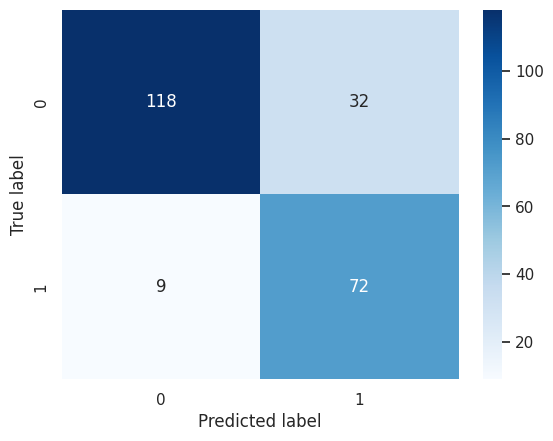

In [45]:
# Instantiate the 1st-layer classifiers
clf_lr = LogisticRegression(C=0.223, solver='newton-cg', class_weight='balanced', random_state=12)
clf_svc = SVC(C=10, gamma=0.0001, class_weight='balanced', probability=True, random_state=12)
clf_xgb = XGBClassifier(objective='binary:logistic', reg_lambda=2, learning_rate=0.05, 
                        max_depth=5, min_child_weight=6, n_estimators=50, 
                        scale_pos_weight=1.872, random_state=12)


# Prepare the list of tuples with the first-layer classifiers
classifiers = [
    ('clf1', clf_svc),
    ('clf2', clf_xgb),
    ('clf3', clf_lr)    
]
    
# Instantiate the second-layer meta estimator
clf_meta = RandomForestClassifier(class_weight='balanced_subsample', max_depth=4, random_state=12)

# Build the stacking classifier
clf_stack = StackingClassifier(
   estimators=classifiers,
   final_estimator=clf_meta,
   passthrough=True)

# Fit the stacking classifier to the training set
clf_stack.fit(X_train_pre, y_train)

# Obtain the final predictions from the stacking classifier
pred_stack = clf_stack.predict(X_test_pre)

# Evaluate the new performance on the test set
acc = accuracy_score(y_test, pred_stack)
bal_acc = balanced_accuracy_score(y_test, pred_stack)
recall = recall_score(y_test, pred_stack)
precision = precision_score(y_test, pred_stack)
f1 = f1_score(y_test, pred_stack)
auc = roc_auc_score(y_test, clf_stack.predict_proba(X_test_pre)[:,1])

# Performance metrics
print(f"Stacked Models:\nAccuracy: {acc:.4f}, Balanced Accuracy: {bal_acc:.4f}\n") 
print(f"ROC AUC: {auc:.4f}, Recall: {recall:.2f}\n")
print(f"Precision: {precision:.2f}, F1 score: {f1:.2f}\n") 

# Print classification report 
print(f" Classification Report\n {classification_report(y_test, pred_stack)}")

# Display confusion matrix
sns.heatmap(confusion_matrix(y_test, pred_stack), annot=True, fmt='.3g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# 7. The Voting Classifier

Voting Classifier:

Accuracy: 0.8095, Balanced Accuracy: 0.8249

ROC AUC: 0.8909, Recall: 0.88
 
Precision: 0.68, F1 score: 0.76

 Classification Report
               precision    recall  f1-score   support

           0       0.92      0.77      0.84       150
           1       0.68      0.88      0.76        81

    accuracy                           0.81       231
   macro avg       0.80      0.82      0.80       231
weighted avg       0.83      0.81      0.81       231



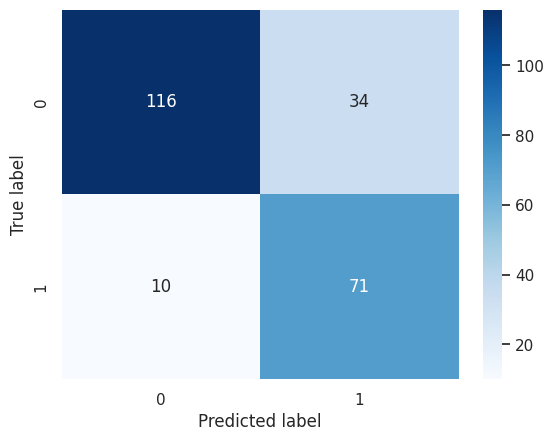

In [46]:
# Create the individual models
clf_rf = RandomForestClassifier(class_weight='balanced_subsample', max_depth=3, 
                                random_state=12)
clf_xgb = XGBClassifier(objective='binary:logistic', reg_lambda=2, learning_rate=0.05, 
                        max_depth=5, min_child_weight=6, n_estimators=50, 
                        scale_pos_weight=1.872, random_state=12)
clf_lr = LogisticRegression(C=0.223, solver='newton-cg', class_weight='balanced', 
                            random_state=12)


# Create voting classifier
clf_voting = VotingClassifier(
    estimators=[
       ('rf', clf_rf),
       ('xgb', clf_xgb),
       ('lr', clf_lr)
       ], voting='soft', weights=[2.5,2,1])

# Fit it to the training set and predict
clf_voting.fit(X_train_pre, y_train)
pred_vot = clf_voting.predict(X_test_pre)

# Evaluate the new performance on the test set
acc = accuracy_score(y_test, pred_vot)
bal_acc = balanced_accuracy_score(y_test, pred_vot)
recall = recall_score(y_test, pred_vot)
precision = precision_score(y_test, pred_vot)
f1 = f1_score(y_test, pred_vot)
auc = roc_auc_score(y_test, clf_voting.predict_proba(X_test_pre)[:,1])

# Print performance metrics
print(f"Voting Classifier:\n\nAccuracy: {acc:.4f}, Balanced Accuracy: {bal_acc:.4f}\n")
print(f"ROC AUC: {auc:.4f}, Recall: {recall:.2f}\n ")
print(f"Precision: {precision:.2f}, F1 score: {f1:.2f}\n")
# Print classification report 
print(f" Classification Report\n {classification_report(y_test, pred_vot)}")

# Display confusion matrix
sns.heatmap(confusion_matrix(y_test, pred_vot), annot=True, fmt='.3g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# 8. Additional Feature engineering

In this section some features are going to be engineered in order to see whether this improves the prediction. First, we create bins to evaluate whether the general magnitude of values rather than their values per se is more important


## 8.1 Binning
Arbitrary binning based on the domain knowledge of diabetes was performed on some of the features. The functions and transformers were based on this article of [Custom Transformers](#Ref). Nested Pipelines were joined using FeatureUnion as outlined in [this](#Ref) DataCamp course. Once the bins were created, they were encoded onehot or ordinal encoded. 

### 8.1.2 Create Functions to Engineer Features
Using OneHotEncoder

In [47]:
# Create a function to engineer the BMI column
def create_bmi_bins(col):
    bmi_bins = [-np.inf, 18.5, 24.9, 29.9, 34.9, 39.9, np.inf]
    bmi_labels = ['underweight', 'normal', 'overweight', 'obese1', 'obese2', 'obese3']
    
    # Instantiate the imputer and dummies encoder objects
    bmi_imputer = KNNImputer(n_neighbors=3)
    bmi_ohe = OneHotEncoder()
   
    
    # Impute missing values 
    imputed = bmi_imputer.fit_transform(col)
    bmi_filled = pd.DataFrame(data=imputed, columns=['BMI'])
    
    # Perform binning
    bmi_cat_cols = pd.cut(bmi_filled['BMI'],bins=bmi_bins, labels=bmi_labels)
    bmi_cats = pd.DataFrame(data= bmi_cat_cols, columns=['BMI'])
    
    # Dummy encoding
    bmi_encoded = bmi_ohe.fit_transform(bmi_cats[['BMI']])
    bmi_encoded = pd.DataFrame(data=bmi_encoded.toarray())
    return bmi_encoded
    
    
# Create function to engineer the Insulin feature
def create_insulin_bins(col):
    insulin_bins = [-np.inf, 16, 166, np.inf]
    insulin_labels = ['low', 'normal', 'high']
    
    # Instantiate the imputer and dummies encoder objects
    insulin_imputer = KNNImputer(n_neighbors=3)
    insulin_ohe = OneHotEncoder()
    
    # Impute missing values 
    imputed = insulin_imputer.fit_transform(col)
    insulin_filled = pd.DataFrame(data=imputed, columns=['Insulin'])
    
    # Perform binning
    insulin_cat_cols = pd.cut(insulin_filled['Insulin'],bins=insulin_bins, labels=insulin_labels)
    insulin_cats = pd.DataFrame(data= insulin_cat_cols, columns=['Insulin'])
    
    # Dummy encoding
    insulin_encoded = insulin_ohe.fit_transform(insulin_cats[['Insulin']])
    insulin_encoded = pd.DataFrame(data=insulin_encoded.toarray())
    return insulin_encoded 

# Create function to engineer the glucose feature
def create_glucose_bins(col):
    glucose_bins = [-np.inf, 120, 140, 199, np.inf]
    glucose_labels = ['low','normal', 'pre', 'overt']
    
    # Instantiate the imputer and dummies encoder objects
    glucose_imputer = KNNImputer(n_neighbors=3)
    glucose_ohe = OneHotEncoder()
    
    # Impute missing values 
    imputed = glucose_imputer.fit_transform(col)
    glucose_filled = pd.DataFrame(data=imputed, columns=['Glucose'])
    
    # Perform binning
    glucose_cat_cols = pd.cut(glucose_filled['Glucose'],bins=glucose_bins, labels=glucose_labels)
    glucose_cats = pd.DataFrame(data= glucose_cat_cols, columns=['Glucose'])
    
    # Dummy encoding
    glucose_encoded = glucose_ohe.fit_transform(glucose_cats[['Glucose']])
    glucose_encoded = pd.DataFrame(data=glucose_encoded.toarray())
    return glucose_encoded

# Create function to engineer the blood pressure feature
def create_bp_bins(col):
    bp_bins = [-np.inf,40, 80, 89, np.inf]
    bp_labels = ['low', 'normal', 'high1', 'high2']
    
    # Instantiate the imputer and dummies encoder objects
    bp_imputer = KNNImputer(n_neighbors=3)
    bp_ohe = OneHotEncoder()
    
    # Impute missing values 
    imputed = bp_imputer.fit_transform(col)
    bp_filled = pd.DataFrame(data=imputed, columns=['BloodPressure'])
    
    # Perform binning
    bp_cat_cols = pd.cut(bp_filled['BloodPressure'],bins=bp_bins, labels=bp_labels)
    bp_cats = pd.DataFrame(data= bp_cat_cols, columns=['BloodPressure'])
    
    # Dummy encoding
    bp_encoded = bp_ohe.fit_transform(bp_cats[['BloodPressure']])
    bp_encoded = pd.DataFrame(data=bp_encoded.toarray())
    return bp_encoded

# Create function to engineer the age feature
def create_age_bins(col):
    age_bins = [18, 30, 40, 50, 60, 70, 120]
    age_labels = ['21-29', '30-39', '40-49', '50-59', '60-69', '70+']
    
    # Instantiate the imputer and dummies encoder objects
    age_imputer = KNNImputer(n_neighbors=3)
    age_ohe = OneHotEncoder()
    
    # Impute missing values 
    imputed = age_imputer.fit_transform(col)
    age_filled = pd.DataFrame(data=imputed, columns=['Age'])
    
    # Perform binning
    age_cat_cols = pd.cut(age_filled['Age'],bins=age_bins, labels=age_labels)
    age_cats = pd.DataFrame(data= age_cat_cols, columns=['Age'])
    
    # Dummy encoding
    age_encoded = age_ohe.fit_transform(age_cats[['Age']])
    age_encoded = pd.DataFrame(data=age_encoded.toarray())
    return age_encoded


### 8.1.3 Preprocess the Features


In [48]:
# Preprocess features
binning_preprocessor = ColumnTransformer(transformers=
                                     [('bmi_transformer', FunctionTransformer(create_bmi_bins, validate=False), ['BMI']),
                                      ('insulin_transformer', FunctionTransformer(create_insulin_bins, validate=False), ['Insulin']),
                                     ('glucose_transformer', FunctionTransformer(create_glucose_bins, validate=False), ['Glucose']),
                                      ('bp_transformer', FunctionTransformer(create_bp_bins, validate=False), ['BloodPressure']),
                                      ('age_transformer', FunctionTransformer(create_age_bins, validate=False), ['Age'])
                                     ])

In [49]:
# Preprocess the other features
get_other_features = FunctionTransformer(lambda x: x[['Pregnancies', 'SkinThickness','DiabetesPedigreeFunction']])

In [50]:
# Create a FeatureUnion with nested pipeline
process_and_join_features = FeatureUnion(
                      transformer_list = [
                          ('binned_features', Pipeline([
                              ('binning_preprocessor', binning_preprocessor)
                              
                          ])),
                          ('other_features', Pipeline([
                              ('selector', get_other_features),
                              ('imputer', KNNImputer(n_neighbors=3)),
                              ('scaler', StandardScaler())
                          ]))
                      ])

In [51]:
# Instantiate nested pipeline
pl = Pipeline([('union', process_and_join_features),
              ('clf', LogisticRegression(C= 0.223, solver='newton-cg', class_weight='balanced', random_state=12))])

In [52]:
# Fit pl to the training data
pl.fit(X_train, y_train)

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('binned_features',
                                                 Pipeline(steps=[('binning_preprocessor',
                                                                  ColumnTransformer(transformers=[('bmi_transformer',
                                                                                                   FunctionTransformer(func=<function create_bmi_bins at 0x78e211d1c9d0>),
                                                                                                   ['BMI']),
                                                                                                  ('insulin_transformer',
                                                                                                   FunctionTransformer(func=<function create_insulin_bins at 0x78e211d1ca60>),
                                                                                                   ['Insulin'])...
                                                                                                   FunctionTransformer(func=<function create_age_bins at 0x78e211d1f010>),
                                                                                                   ['Age'])]))])),
                                                ('other_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function <lambda> at 0x78e211d1f910>)),
                                                                 ('imputer',
                                                                  KNNImputer(n_neighbors=3)),
                                                                 ('scaler',
                                                                  StandardScaler())]))])),
                ('clf',
                 LogisticRegression(C=0.223, class_weight='balanced',
                                    random_state=12, solver='newton-cg'))])

Logreg with binned features:
Accuracy: 0.7965, Balanced Accuracy: 0.8007

ROC AUC: 0.8747, Recall: 0.81

Precision: 0.67, F1 score: 0.74

 Classification Report
               precision    recall  f1-score   support

           0       0.89      0.79      0.83       150
           1       0.67      0.81      0.74        81

    accuracy                           0.80       231
   macro avg       0.78      0.80      0.79       231
weighted avg       0.81      0.80      0.80       231



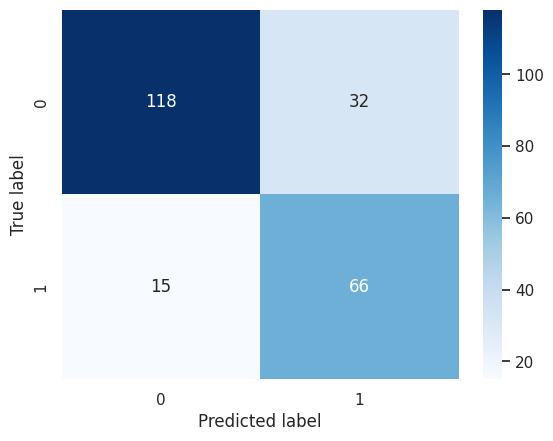

In [53]:
# Make predictions on the test set
pl_pred = pl.predict(X_test)

# Calculate performance metrics
acc = accuracy_score(y_test, pl_pred)
bal_acc = balanced_accuracy_score(y_test, pl_pred)
recall = recall_score(y_test, pl_pred)
precision = precision_score(y_test, pl_pred)
f1 = f1_score(y_test, pl_pred)
auc = roc_auc_score(y_test, pl.predict_proba(X_test)[:,1])

print(f"Logreg with binned features:\nAccuracy: {acc:.4f}, Balanced Accuracy: {bal_acc:.4f}\n")
print(f"ROC AUC: {auc:.4f}, Recall: {recall:.2f}\n")
print(f"Precision: {precision:.2f}, F1 score: {f1:.2f}\n")

# Print classification report 
print(f" Classification Report\n {classification_report(y_test, pl_pred)}")

# Display confusion matrix
sns.heatmap(confusion_matrix(y_test, pl_pred), annot=True, fmt='.3g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

### 8.1.4 Preprocess Features
Using Ordinal Encoder

In [54]:
# Create a function to engineer the BMI column
def create_bmi_bins(col):
    bmi_bins = [-np.inf, 18.5, 24.9, 29.9, 34.9, 39.9, np.inf]
    bmi_labels = ['underweight', 'normal', 'overweight', 'obese1', 'obese2', 'obese3']
    ordinal_bmi = [['obese3', 'obese2', 'obese1', 'overweight', 'underweight', 'normal']] 
    
    # Instantiate the imputer and ordinal encoder objects
    bmi_imputer = KNNImputer(n_neighbors=3)
    bmi_oe = OrdinalEncoder(categories=ordinal_bmi)
   
    
    # Impute missing values 
    imputed = bmi_imputer.fit_transform(col)
    bmi_filled = pd.DataFrame(data=imputed, columns=['BMI'])
    
    # Perform binning
    bmi_cat_cols = pd.cut(bmi_filled['BMI'],bins=bmi_bins, labels=bmi_labels)
    bmi_cats = pd.DataFrame(data= bmi_cat_cols, columns=['BMI'])
    
    # Ordinal encoding
    bmi_encoded = bmi_oe.fit_transform(bmi_cats[['BMI']])
    bmi_encoded = pd.DataFrame(data=bmi_encoded)
    return bmi_encoded

    
    
# Create function to engineer the Insulin feature
def create_insulin_bins(col):
    insulin_bins = [-np.inf, 16, 166, np.inf]
    insulin_labels = ['low', 'normal', 'high']
    ordinal_insulin = [['high', 'low', 'normal']]
    
    # Instantiate the imputer and ordinal encoder objects
    insulin_imputer = KNNImputer(n_neighbors=3)
    insulin_oe = OrdinalEncoder(categories=ordinal_insulin)
    
    # Impute missing values 
    imputed = insulin_imputer.fit_transform(col)
    insulin_filled = pd.DataFrame(data=imputed, columns=['Insulin'])
    
    # Perform binning
    insulin_cat_cols = pd.cut(insulin_filled['Insulin'],bins=insulin_bins, labels=insulin_labels)
    insulin_cats = pd.DataFrame(data= insulin_cat_cols, columns=['Insulin'])
    
    # Ordinal encoding
    insulin_encoded = insulin_oe.fit_transform(insulin_cats[['Insulin']])
    insulin_encoded = pd.DataFrame(data=insulin_encoded)
    return insulin_encoded 

# Create function to engineer the glucose feature
def create_glucose_bins(col):
    glucose_bins = [-np.inf, 120, 140, 199, np.inf]
    glucose_labels = ['low','normal', 'pre', 'overt']
    ordinal_glucose = [['overt', 'pre', 'low', 'normal']]
    
    # Instantiate the imputer and ordinal encoder objects
    glucose_imputer = KNNImputer(n_neighbors=3)
    glucose_oe = OrdinalEncoder()
    
    # Impute missing values 
    imputed = glucose_imputer.fit_transform(col)
    glucose_filled = pd.DataFrame(data=imputed, columns=['Glucose'])
    
    # Perform binning
    glucose_cat_cols = pd.cut(glucose_filled['Glucose'],bins=glucose_bins, labels=glucose_labels)
    glucose_cats = pd.DataFrame(data= glucose_cat_cols, columns=['Glucose'])
    
    # Ordinal encoding
    glucose_encoded = glucose_oe.fit_transform(glucose_cats[['Glucose']])
    glucose_encoded = pd.DataFrame(data=glucose_encoded)
    return glucose_encoded

# Create function to engineer the blood pressure feature
def create_bp_bins(col):
    bp_bins = [-np.inf,40, 80, 89, np.inf]
    bp_labels = ['low', 'normal', 'high1', 'high2']
    ordinal_bp = [['high2', 'high1', 'low', 'normal']]
    
    # Instantiate the imputer and ordinal encoder objects
    bp_imputer = KNNImputer(n_neighbors=3)
    bp_oe = OrdinalEncoder(categories=ordinal_bp)
    
    # Impute missing values 
    imputed = bp_imputer.fit_transform(col)
    bp_filled = pd.DataFrame(data=imputed, columns=['BloodPressure'])
    
    # Perform binning
    bp_cat_cols = pd.cut(bp_filled['BloodPressure'],bins=bp_bins, labels=bp_labels)
    bp_cats = pd.DataFrame(data= bp_cat_cols, columns=['BloodPressure'])
    
    # Ordinal encoding
    bp_encoded = bp_oe.fit_transform(bp_cats[['BloodPressure']])
    bp_encoded = pd.DataFrame(data=bp_encoded)
    return bp_encoded

# Create function to engineer the age feature
def create_age_bins(col):
    age_bins = [18, 30, 40, 50, 60, 70, 120]
    age_labels = ['21-29', '30-39', '40-49', '50-59', '60-69', '70+']
    ordinal_age = [['50-59', '40-49', '30-39', '21-29', '60-69','70+']]
    
    # Instantiate the imputer and ordinal encoder objects
    age_imputer = KNNImputer(n_neighbors=3)
    age_oe = OrdinalEncoder(categories=ordinal_age)
    
    # Impute missing values 
    imputed = age_imputer.fit_transform(col)
    age_filled = pd.DataFrame(data=imputed, columns=['Age'])
    
    # Perform binning
    age_cat_cols = pd.cut(age_filled['Age'],bins=age_bins, labels=age_labels)
    age_cats = pd.DataFrame(data= age_cat_cols, columns=['Age'])
    
    # Ordinal encoding
    age_encoded = age_oe.fit_transform(age_cats[['Age']])
    age_encoded = pd.DataFrame(data=age_encoded)
    return age_encoded


In [55]:
# Preprocess features
binning_preprocessor = ColumnTransformer(transformers=
                                     [('bmi_transformer', FunctionTransformer(create_bmi_bins, validate=False), ['BMI']),
                                      ('insulin_transformer', FunctionTransformer(create_insulin_bins, validate=False), ['Insulin']),
                                     ('glucose_transformer', FunctionTransformer(create_glucose_bins, validate=False), ['Glucose']),
                                      ('bp_transformer', FunctionTransformer(create_bp_bins, validate=False), ['BloodPressure']),
                                      ('age_transformer', FunctionTransformer(create_age_bins, validate=False), ['Age'])
                                     ])

In [56]:
# Preprocess the other features
get_other_features = FunctionTransformer(lambda x: x[['Pregnancies', 'SkinThickness','DiabetesPedigreeFunction']])

In [57]:
# Create a FeatureUnion with nested pipeline
process_and_join_features = FeatureUnion(
                      transformer_list = [
                          ('binned_features', Pipeline([
                              ('binning_preprocessor', binning_preprocessor)
                              
                          ])),
                          ('other_features', Pipeline([
                              ('selector', get_other_features),
                              ('imputer', KNNImputer(n_neighbors=3)),
                              ('scaler', StandardScaler())
                          ]))
                      ])

In [58]:
# Instantiate nested pipeline
pl = Pipeline([('union', process_and_join_features),
              ('clf', LogisticRegression(C= 0.223, solver='newton-cg', class_weight='balanced', random_state=12))])

In [59]:
# Fit pl to the training data
pl.fit(X_train, y_train)

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('binned_features',
                                                 Pipeline(steps=[('binning_preprocessor',
                                                                  ColumnTransformer(transformers=[('bmi_transformer',
                                                                                                   FunctionTransformer(func=<function create_bmi_bins at 0x78e211e396c0>),
                                                                                                   ['BMI']),
                                                                                                  ('insulin_transformer',
                                                                                                   FunctionTransformer(func=<function create_insulin_bins at 0x78e211e3a8c0>),
                                                                                                   ['Insulin'])...
                                                                                                   FunctionTransformer(func=<function create_age_bins at 0x78e211e38d30>),
                                                                                                   ['Age'])]))])),
                                                ('other_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function <lambda> at 0x78e211e3a0e0>)),
                                                                 ('imputer',
                                                                  KNNImputer(n_neighbors=3)),
                                                                 ('scaler',
                                                                  StandardScaler())]))])),
                ('clf',
                 LogisticRegression(C=0.223, class_weight='balanced',
                                    random_state=12, solver='newton-cg'))])

Logreg with binned features:
Accuracy: 0.7879, Balanced Accuracy: 0.7998

ROC AUC: 0.8689, Recall: 0.84

Precision: 0.65, F1 score: 0.74

 Classification Report
               precision    recall  f1-score   support

           0       0.90      0.76      0.82       150
           1       0.65      0.84      0.74        81

    accuracy                           0.79       231
   macro avg       0.78      0.80      0.78       231
weighted avg       0.81      0.79      0.79       231



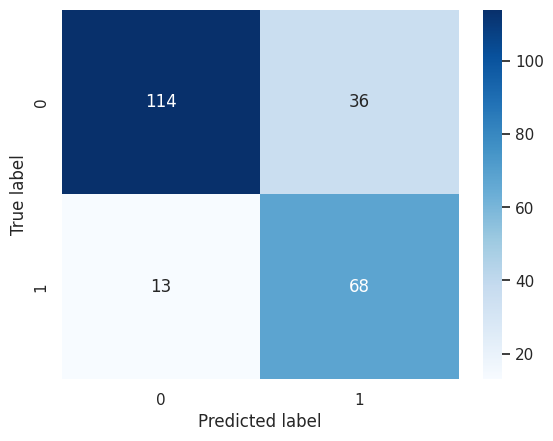

In [60]:
# Make predictions on the test set
pl_pred = pl.predict(X_test)

# Calculate performance metrics
acc = accuracy_score(y_test, pl_pred)
bal_acc = balanced_accuracy_score(y_test, pl_pred)
recall = recall_score(y_test, pl_pred)
precision = precision_score(y_test, pl_pred)
f1 = f1_score(y_test, pl_pred)
auc = roc_auc_score(y_test, pl.predict_proba(X_test)[:,1])

print(f"Logreg with binned features:\nAccuracy: {acc:.4f}, Balanced Accuracy: {bal_acc:.4f}\n")
print(f"ROC AUC: {auc:.4f}, Recall: {recall:.2f}\n")
print(f"Precision: {precision:.2f}, F1 score: {f1:.2f}\n")

# Print classification report 
print(f" Classification Report\n {classification_report(y_test, pl_pred)}")

# Display confusion matrix
sns.heatmap(confusion_matrix(y_test, pl_pred), annot=True, fmt='.3g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

## 8.2 Log Transformation
Some of the features have skewed distributions so log transformation is going to be applied.

### 8.2.1 Functions to transform features

In [61]:
# Create a function to transform the insulin feature
def transform_insulin(col):
    
    # Instantiate the PowerTransformer and imputer objects
    ins_trans = PowerTransformer()
    imputer = KNNImputer(n_neighbors=3)
    
    # Impute
    col_imputed = imputer.fit_transform(col)
    ins_filled = pd.DataFrame(data=col_imputed, columns=['Insulin'])
    
    # Apply the power transform
    ins_transformed = ins_trans.fit_transform(ins_filled[['Insulin']])
   
    return ins_transformed

# Create a function to transform the PedigreeFunction feature
def transform_pedigree(col):
    
    # Instantiate the PowerTransformer and imputer objects
    pedi_trans = PowerTransformer()
    imputer = KNNImputer(n_neighbors=3)
    
    # Impute
    col_imputed = imputer.fit_transform(col)
    pedi_filled = pd.DataFrame(data=col_imputed, columns=['DiabetesPedigreeFunction'])
    
    # Apply the power transform
    pedi_transformed = pedi_trans.fit_transform(pedi_filled[['DiabetesPedigreeFunction']])
   
    return pedi_transformed

# Create a function to transform the Age feature
def transform_age(col):
    
    # Instantiate the PowerTransformer and imputer objects
    age_trans = MinMaxScaler()
    imputer = KNNImputer(n_neighbors=3)
    
    # Impute
    col_imputed = imputer.fit_transform(col)
    age_filled = pd.DataFrame(data=col_imputed, columns=['Age'])
    
    # Apply the power transform
    age_transformed = age_trans.fit_transform(age_filled[['Age']])
   
    return age_transformed

# Create a function to transform the BMI feature
def transform_bmi(col):
    
    # Instantiate the PowerTransformer and imputer objects
    bmi_trans = PowerTransformer()
    imputer = KNNImputer(n_neighbors=3)
    
    # Impute
    col_imputed = imputer.fit_transform(col)
    bmi_filled = pd.DataFrame(data=col_imputed, columns=['bmi'])
    
    # Apply the power transform
    bmi_transformed = bmi_trans.fit_transform(bmi_filled[['bmi']])
   
    return bmi_transformed

# Create a function to transform the Pregnancies feature
def transform_preg(col):
    
    # Instantiate the PowerTransformer and imputer objects
    preg_trans = PowerTransformer()
    imputer = KNNImputer(n_neighbors=3)
    
    # Impute
    col_imputed = imputer.fit_transform(col)
    preg_filled = pd.DataFrame(data=col_imputed, columns=['Pregnancies'])
    
    # Apply the power transform
    preg_transformed = preg_trans.fit_transform(preg_filled[['Pregnancies']])
   
    return preg_transformed



### 8.2.2 Preprocess the features

In [62]:
# Preprocess features
log_preprocessor = ColumnTransformer(transformers=
                                    [('insulin_transformer', FunctionTransformer(transform_insulin, validate=False), ['Insulin']),
                                    ('pedi_transformer', FunctionTransformer(transform_pedigree, validate=False), ['DiabetesPedigreeFunction']),
                                    ('age_transformer', FunctionTransformer(transform_age, validate=False), ['Age']),
                                    ('preg_transformer', FunctionTransformer(transform_preg, validate=False), ['Pregnancies']),
                                    ('bmi_transformer', FunctionTransformer(transform_bmi, validate=False), ['BMI'])
                                    
                                    ])
            

In [63]:
# Preprocess other features
get_other_features = FunctionTransformer(lambda x: x[['BloodPressure', 'Glucose', 'SkinThickness']])

In [64]:
# Create a FeatureUnion with nested pipeline
process_and_join_features = FeatureUnion(
                      transformer_list = [
                          ('log_transformed', Pipeline([
                              ('log_preprocessor', log_preprocessor)
                              
                          ])),
                          ('other_features', Pipeline([
                              ('selector', get_other_features),
                              ('imputer', KNNImputer(n_neighbors=3)),
                              ('scaler', StandardScaler())
                          ]))
                      ])

In [65]:
# Instantiate nested pipeline
pl2 = Pipeline([('union', process_and_join_features),
              ('clf', LogisticRegression(C=0.223, solver='newton-cg', class_weight='balanced', 
                            random_state=12))])

In [66]:
# Fit pl to the training data
pl2.fit(X_train, y_train)

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('log_transformed',
                                                 Pipeline(steps=[('log_preprocessor',
                                                                  ColumnTransformer(transformers=[('insulin_transformer',
                                                                                                   FunctionTransformer(func=<function transform_insulin at 0x78e211e3bc70>),
                                                                                                   ['Insulin']),
                                                                                                  ('pedi_transformer',
                                                                                                   FunctionTransformer(func=<function transform_pedigree at 0x78e211e3a5f0>),
                                                                                                   ['Diabetes...
                                                                                                   FunctionTransformer(func=<function transform_bmi at 0x78e2199c6560>),
                                                                                                   ['BMI'])]))])),
                                                ('other_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function <lambda> at 0x78e2199c68c0>)),
                                                                 ('imputer',
                                                                  KNNImputer(n_neighbors=3)),
                                                                 ('scaler',
                                                                  StandardScaler())]))])),
                ('clf',
                 LogisticRegression(C=0.223, class_weight='balanced',
                                    random_state=12, solver='newton-cg'))])

Logreg with power transform:
Accuracy: 0.7922, Balanced Accuracy: 0.7917

ROC AUC: 0.8808, Recall: 0.79

Precision: 0.67, F1 score: 0.73

 Classification Report
               precision    recall  f1-score   support

           0       0.88      0.79      0.83       150
           1       0.67      0.79      0.73        81

    accuracy                           0.79       231
   macro avg       0.77      0.79      0.78       231
weighted avg       0.80      0.79      0.80       231




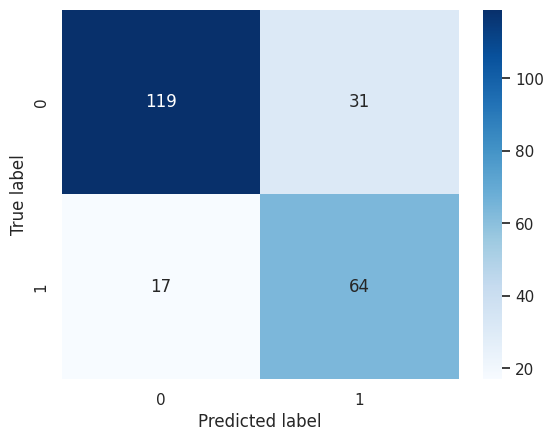

In [67]:
# Make predictions on the test set
pl2_pred = pl2.predict(X_test)

# Get performance metrics
acc = accuracy_score(y_test, pl2_pred)
bal_acc = balanced_accuracy_score(y_test, pl2_pred)
recall = recall_score(y_test, pl2_pred)
precision = precision_score(y_test, pl2_pred)
f1 = f1_score(y_test, pl2_pred)
auc = roc_auc_score(y_test, pl2.predict_proba(X_test)[:,1])

# Print performance metrics
print(f"Logreg with power transform:\nAccuracy: {acc:.4f}, Balanced Accuracy: {bal_acc:.4f}\n")
print(f"ROC AUC: {auc:.4f}, Recall: {recall:.2f}\n")
print(f"Precision: {precision:.2f}, F1 score: {f1:.2f}\n")

# Print classification report 
print(f" Classification Report\n {classification_report(y_test, pl2_pred)}\n")

# Display confusion matrix
sns.heatmap(confusion_matrix(y_test, pl2_pred), annot=True, fmt='.3g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

## 8.3 Outlier removal
The features `Insulin` and `DiabetesPedigreeFuntion` had skewness above 1 which might result in underperformance of the logistic regression, SVC and K-neighbour's models.

- The outliers were identified using the interquartile (IQR) range method. The cutoff was $1.5 * IQR \pm $ 75th and 25th percentiles.
- The outlier values were then imputed to those of the threshold values (clipped).



In [68]:
# Create a function to clip outliers
def clip_outliers(df, col):
    
    # Calculate the 25th and 75th percentiles
    q1 = df[col].quantile(q=0.25)
    q3 = df[col].quantile(q=0.75)
    
    # Calculate the interquartile range
    iqr = q3 - q1
    
    # Get the lower and upper outliers
    lower = (q1 - 1.5 * iqr)
    upper = (q3 + 1.5 * iqr)
    
    df[col] = df[col].clip(lower, upper)
    return df[col]

In [69]:
# Make a copy of the original DataFrame
diabetes_df2 = diabetes_df.copy()

# Clip the outliers in the Insulin and DiabetesPedgreeFunction features
diabetes_df2['Insulin'] = clip_outliers(diabetes_df2, 'Insulin')
diabetes_df2['DiabetesPedigreeFunction'] = clip_outliers(diabetes_df2, 'DiabetesPedigreeFunction')

# Display the skewness before and after clipping
print(f"Insulin skewness before: {diabetes_df['Insulin'].skew()},\
    after: {diabetes_df2['Insulin'].skew()}")
print(f"Insulin skewness before: {diabetes_df['DiabetesPedigreeFunction'].skew()},\
    after: {diabetes_df2['DiabetesPedigreeFunction'].skew()}")

Insulin skewness before: 2.166463843812443,    after: 0.9539010274825211
Insulin skewness before: 1.919911066307204,    after: 1.0244278033317116


In [70]:
# Create feature matrix and target array
X = diabetes_df2.drop('Outcome', axis=1)
y = diabetes_df2.Outcome
print(X.shape, y.shape)

(768, 8) (768,)


In [71]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=12)

In [72]:
# Build a Pipeline
clf_pipe2 = Pipeline(steps=[
    ('imputation', KNNImputer(n_neighbors=3)),
    ('scaler', StandardScaler()),
    ('model', SVC(C=10, gamma=0.0001, class_weight='balanced', probability=True, random_state=12))
])

# Fit the Pipeline
clf_pipe2.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf_pipe2.predict(X_test)

# Calculate prediction metrics
acc = accuracy_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, clf_pipe2.predict_proba(X_test)[:,1])

# Print the metrics
print(f"SVC with outliers clipped:\nAccuracy: {acc:.4f}, Balanced Accuracy: {bal_acc:.4f}\n")
print(f"ROC AUC: {auc:.4f}, Recall: {recall:.2f}\n")
print(f"Precision: {precision:.2f}, F1 score: {f1:.2f}\n")

SVC with outliers clipped:
Accuracy: 0.7706, Balanced Accuracy: 0.7779

ROC AUC: 0.8574, Recall: 0.80

Precision: 0.64, F1 score: 0.71



- The SVC model benefited from outlier clipping. The recall and F1-scores were 0.74 and 0.68 before and went up to 0.80 and 0.71 respectively.
- The logistic regression model did not benefit from outlier clipping. 


### 8.3.1 Feature Importances

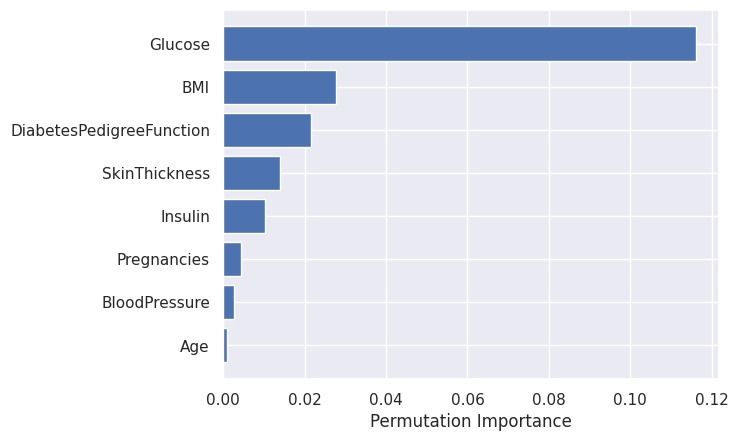

In [73]:
# Calculate permutation importances
perm_importance = permutation_importance(clf_pipe2, X_test, y_test, random_state=41)

# Get the feature names
feature_names = X_train.columns
features = np.array(feature_names)

# Sort and plot
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

- `Glucose` is by far the most predictive feature.
- Before outlier clipping, only `Glucose` and `DiabetesPedigreeFunction` had a positive impact. Now none of the features has a negative impact.
- `BloodPressure`, `Age` and `Pregnancies` were the least impactful.

# 9. Summary

## 9.1 Performance Metrics

In [74]:
df = pd.DataFrame({'model':['SVC', 'SVC_no_outl', "LR", 'LR_bin_ohe','LR_bin_oe', 'LR_pow', 'XGB', 'RF', 'Stack', 'Vote'], 
                   'AUC': [0.856, 0.857, 0.877, 0.875, 0.869, 0.881, 0.888, 0.880, 0.887, 0.891 ],
                  'Accuracy': [0.758, 0.771, 0.797, 0.797, 0.788, 0.792, 0.801, 0.831, 0.823, 0.810],
                  'Balanced Accuracy': [0.754, 0.778, 0.798, 0.801, 0.800, 0.792, 0.813, 0.842, 0.838, 0.825],
                  'Recall' : [0.74, 0.80, 0.8, 0.81, 0.84, 0.79, 0.85, 0.88, 0.89, 0.88],
                  'F1 Score' :[0.68, 0.71, 0.73, 0.74, 0.74, 0.73, 0.75, 0.78, 0.78, 0.76],
                  'Precision': [0.63, 0.64, 0.68, 0.67, 0.65, 0.67, 0.67, 0.71, 0.69, 0.68],
                  'Rank': [9, 8, 7, 6, 5, 8, 4, 2, 1, 3]})
df

,model,AUC,Accuracy,Balanced Accuracy,Recall,F1 Score,Precision,Rank
0,SVC,0.856,0.758,0.754,0.74,0.68,0.63,9
1,SVC_no_outl,0.857,0.771,0.778,0.80,0.71,0.64,8
2,LR,0.877,0.797,0.798,0.80,0.73,0.68,7
3,LR_bin_ohe,0.875,0.797,0.801,0.81,0.74,0.67,6
4,LR_bin_oe,0.869,0.788,0.800,0.84,0.74,0.65,5
5,LR_pow,0.881,0.792,0.792,0.79,0.73,0.67,8
6,XGB,0.888,0.801,0.813,0.85,0.75,0.67,4
7,RF,0.880,0.831,0.842,0.88,0.78,0.71,2
8,Stack,0.887,0.823,0.838,0.89,0.78,0.69,1
9,Vote,0.891,0.810,0.825,0.88,0.76,0.68,3


- Rank was based on recall and f1 scores
- The best model was the StackingClassifier which just edged off the RandomForestClassifier by 1% on the recall score.
- Binning features in combination with onehot encoding improved the logistic regression recall score by only 1%.
- Binning features in combination with ordinal encoding improved the recall score of the logistic model by 5%.
- Power transformation did not improve the recall score of the logistic regression.
- The worst model in predicting diabetes was SVC. 
- Performance of SVC model was improved by eliminating outliers. Recall score  increased by 8%.

## 9.2 Overall Feature Importance

In [75]:
features = pd.DataFrame({'model': ['LR', 'RF', 'xgb', 'svc', 'svc_out'],
                        'Rank1': ['glucose', 'glucose', 'glucose', 'glucose', 'glucose'],
                        'Rank2': ['bmi', 'insulin', 'insulin', 'dpf', 'bmi'],
                        'Rank3': ['preg', 'bmi', 'age', 'bmi', 'dpf'],
                        'Rank4': ['dpf', 'age', 'bmi', 'insulin', 'skin'],
                        'Rank5': ['age', 'skin', 'preg', 'preg', 'insulin'],
                        'Rank6': ['insulin', 'preg', 'skin', 'skin', 'preg'],
                        'Rank7': ['skin', 'dpf', 'bp', 'bp', 'bp'],
                        'Rank8': ['bp', 'bp', 'dpf', 'age', 'age']})
features

,model,Rank1,Rank2,Rank3,Rank4,Rank5,Rank6,Rank7,Rank8
0,LR,glucose,bmi,preg,dpf,age,insulin,skin,bp
1,RF,glucose,insulin,bmi,age,skin,preg,dpf,bp
2,xgb,glucose,insulin,age,bmi,preg,skin,bp,dpf
3,svc,glucose,dpf,bmi,insulin,preg,skin,bp,age
4,svc_out,glucose,bmi,dpf,skin,insulin,preg,bp,age


# 10. Conclusions
- The best model to predict diabetes was the RandomForest model. 
- Data preprocessing involved imputation using KNNImputer and scaling using StandardScaler.
- `Glucose` was deemed the most important feature for predicting diabetes by all models. Other important features were `Insulin`, `BMI` and `Age`.
- `BloodPressure` was the least important feature with the logistic regression and the random forest model and second least import with SVC and gradient boost models.

<a id='Ref'></a>
# 11. References
1. [WHO](https://www.who.int/health-topics/diabetes#tab=tab_1)
2. [FreeCodeCamp](https://www.freecodecamp.org/news/machine-learning-pipeline/) 
3. [DataCamp](https://campus.datacamp.com/courses/case-study-school-budgeting-with-machine-learning-in-python/improving-your-model?ex=4)
4. [Custom Transformers](https://www.linkedin.com/pulse/data-science-quick-tip-004-using-custom-transformers-david-hundley)